In [20]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)

train_df = pd.read_csv(r"/kaggle/input/house-prices-advanced-regression-techniques/train.csv")


In [22]:
# Data types
print("\nSummary of data types:")
print(train_df.dtypes.to_string())


Summary of data types:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
H

In [23]:
#Handle missing values
print("\nMissing Values in categorical features before imputing:\n")
for col in train_df.columns:
    if train_df[col].isna().sum() != 0 and train_df[col].dtype == object:
        print("{} has {} missing values".format(col,train_df[col].isna().sum()))

for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].fillna("Not_Available")

print("\nMissing Values in numerical features before imputing:\n")
for col in train_df.columns:
    if train_df[col].isna().sum() != 0 and train_df[col].dtype != object:
        print("{} has {} missing values".format(col,train_df[col].isna().sum()))

for column in train_df.columns:
    if train_df[column].dtype == float or train_df[column].dtype == int:
        train_df[column] = train_df[column].fillna(0)

categorical_columns = [col for col in train_df.columns if train_df[col].dtype == object]

integer_columns = [col for col in train_df.columns if train_df[col].dtype != object]

integer_columns.remove("Id")

integer_columns_without_target = [col for col in integer_columns if col != "SalePrice"]



Missing Values in categorical features before imputing:

Alley has 1369 missing values
MasVnrType has 872 missing values
BsmtQual has 37 missing values
BsmtCond has 37 missing values
BsmtExposure has 38 missing values
BsmtFinType1 has 37 missing values
BsmtFinType2 has 38 missing values
Electrical has 1 missing values
FireplaceQu has 690 missing values
GarageType has 81 missing values
GarageFinish has 81 missing values
GarageQual has 81 missing values
GarageCond has 81 missing values
PoolQC has 1453 missing values
Fence has 1179 missing values
MiscFeature has 1406 missing values

Missing Values in numerical features before imputing:

LotFrontage has 259 missing values
MasVnrArea has 8 missing values
GarageYrBlt has 81 missing values


In [24]:
# Finding feature pairs with high correlation
train_df_coded = train_df.copy()

for i in categorical_columns:
    train_df_coded[i + '_coded'] = LabelEncoder().fit_transform(train_df_coded[i])

train_df_coded = train_df_coded.drop(categorical_columns, axis = 1)

train_df_coded_corr_matrix = train_df_coded.corr()

high_correlation_pairs = (train_df_coded_corr_matrix.abs() >= 0.6) & (train_df_coded_corr_matrix != 1)

upper_triangle_indices = zip(*np.triu_indices_from(train_df_coded_corr_matrix, k=1))

unique_pairs = [(train_df_coded_corr_matrix.index[i], 
                 train_df_coded_corr_matrix.columns[j], 
                 train_df_coded_corr_matrix.iloc[i, j]) for i, j in upper_triangle_indices if high_correlation_pairs.iloc[i, j]]

unique_pairs_df = pd.DataFrame(unique_pairs, columns=['Feature_1', 'Feature_2', 'Correlation'])

print("\nUnique Pairs with High Correlation:")
print(unique_pairs_df)

'''
It is observed from the correlation matrix that the sales price of a house is strongly correlated with the following features:
    1) OverallQual - Overall material and finish quality
    2) TotalBsmtSF - Total square feet of basement area
    3) 1stFlrSF - First Floor square feet
    4) GrLivArea - Above grade (ground) living area square feet
    5) GarageCars - Size of garage in car capacity
    6) GarageArea - Size of garage in square feet
    7) ExterQual - Exterior material quality
'''


Unique Pairs with High Correlation:
            Feature_1           Feature_2  Correlation
0          MSSubClass      BldgType_coded     0.746063
1         OverallQual          GarageCars     0.600671
2         OverallQual           SalePrice     0.790982
3         OverallQual     ExterQual_coded    -0.634319
4           YearBuilt    Foundation_coded     0.634842
5           YearBuilt      BsmtQual_coded    -0.608569
6          BsmtFinSF1        BsmtFullBath     0.649212
7          BsmtFinSF2  BsmtFinType2_coded    -0.706303
8         TotalBsmtSF            1stFlrSF     0.819530
9         TotalBsmtSF           SalePrice     0.613581
10           1stFlrSF           SalePrice     0.605852
11           2ndFlrSF           GrLivArea     0.687501
12           2ndFlrSF            HalfBath     0.609707
13           2ndFlrSF        TotRmsAbvGrd     0.616423
14          GrLivArea            FullBath     0.630012
15          GrLivArea        TotRmsAbvGrd     0.825489
16          GrLivArea       

'\nIt is observed from the correlation matrix that the sales price of a house is strongly correlated with the following features:\n    1) OverallQual - Overall material and finish quality\n    2) TotalBsmtSF - Total square feet of basement area\n    3) 1stFlrSF - First Floor square feet\n    4) GrLivArea - Above grade (ground) living area square feet\n    5) GarageCars - Size of garage in car capacity\n    6) GarageArea - Size of garage in square feet\n    7) ExterQual - Exterior material quality\n'

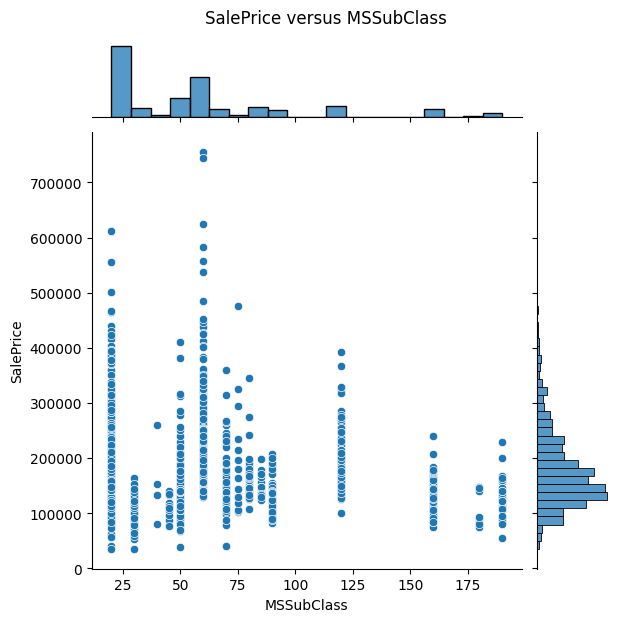

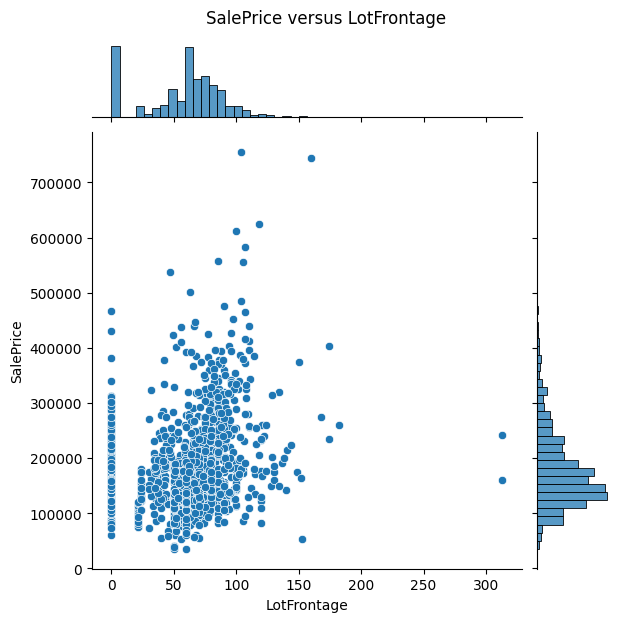

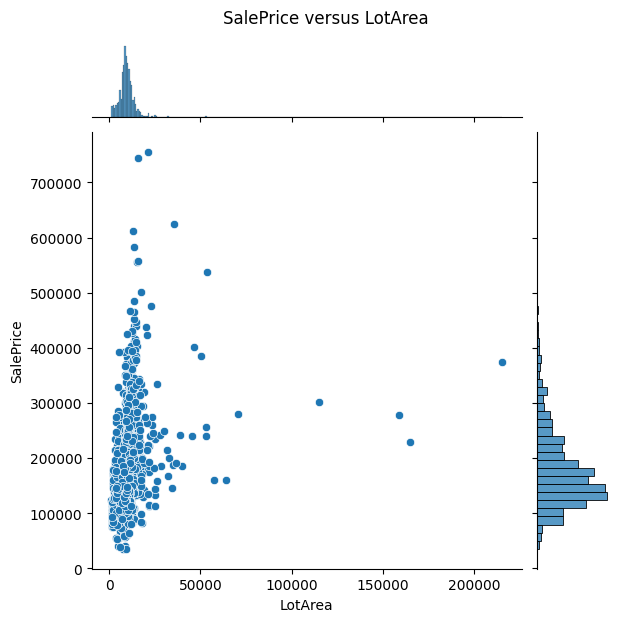

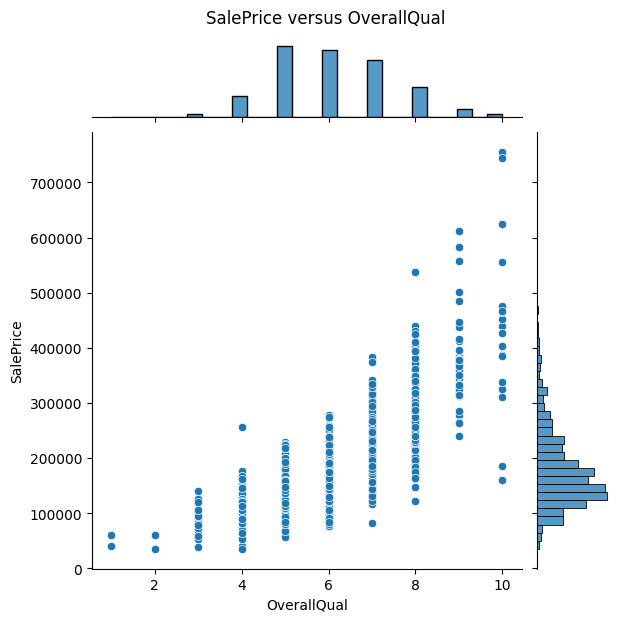

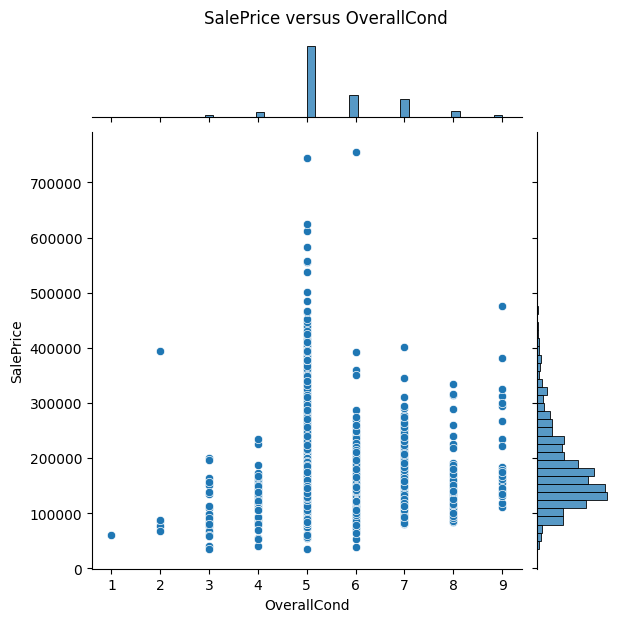

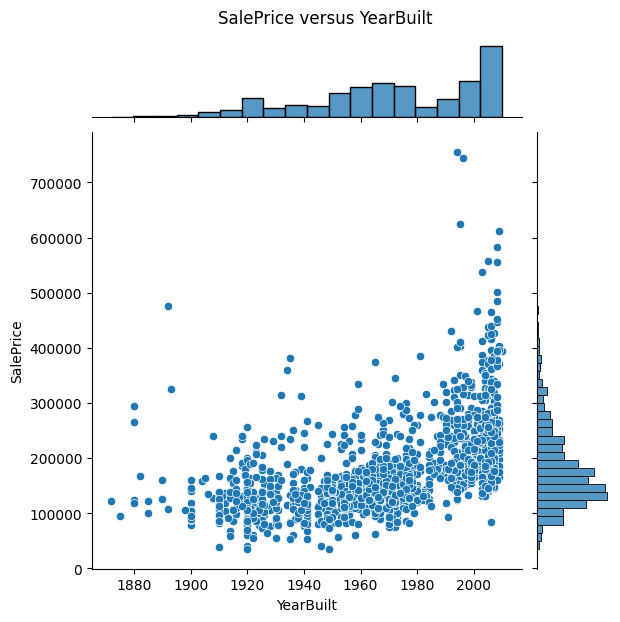

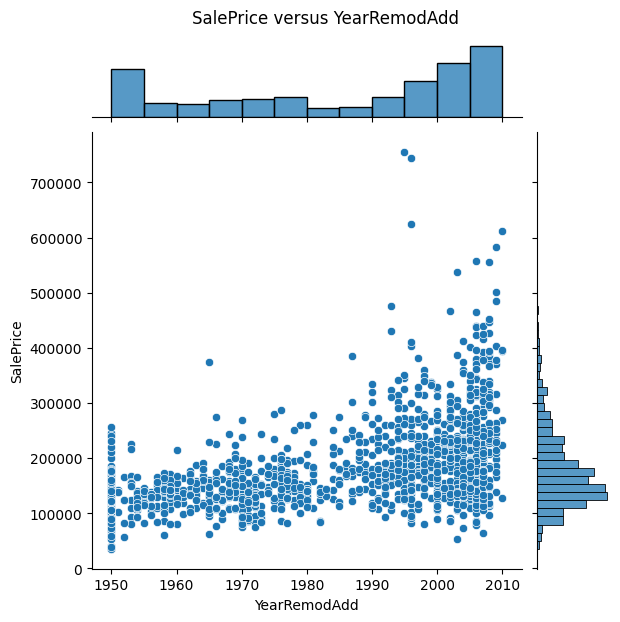

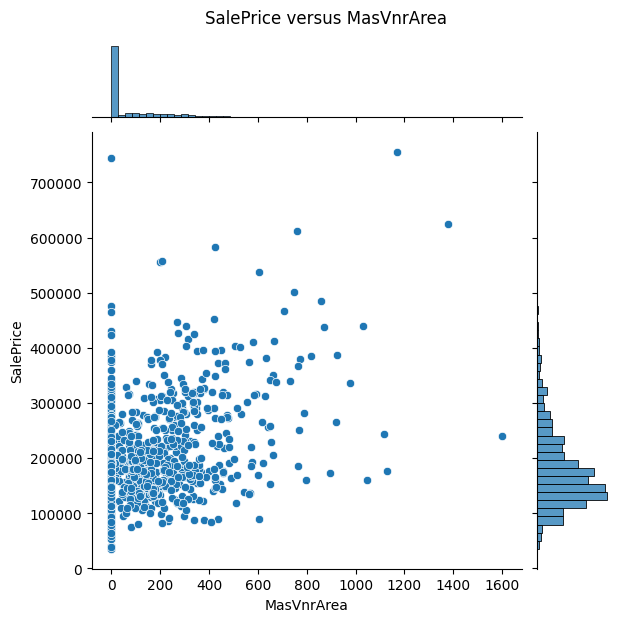

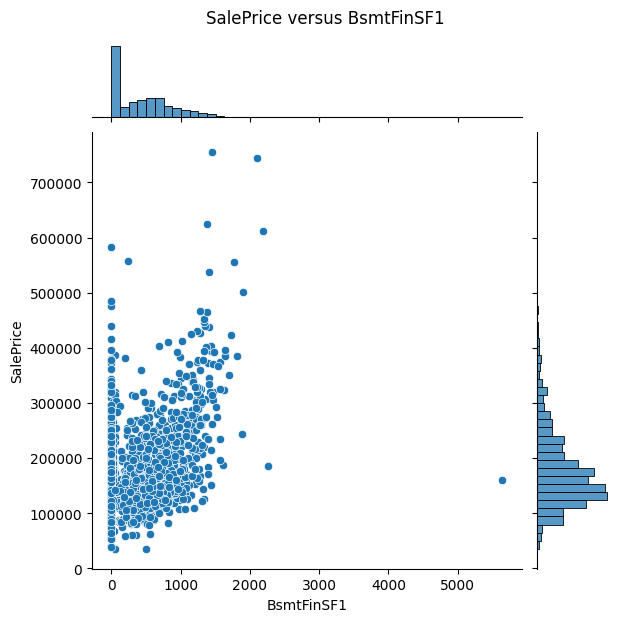

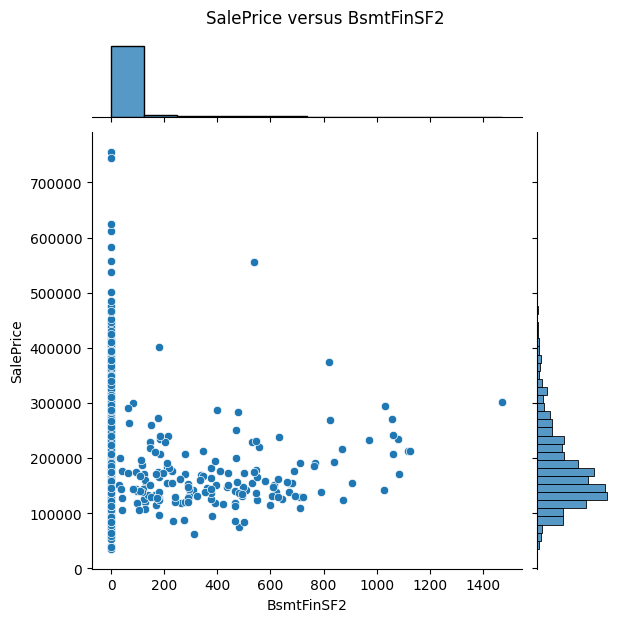

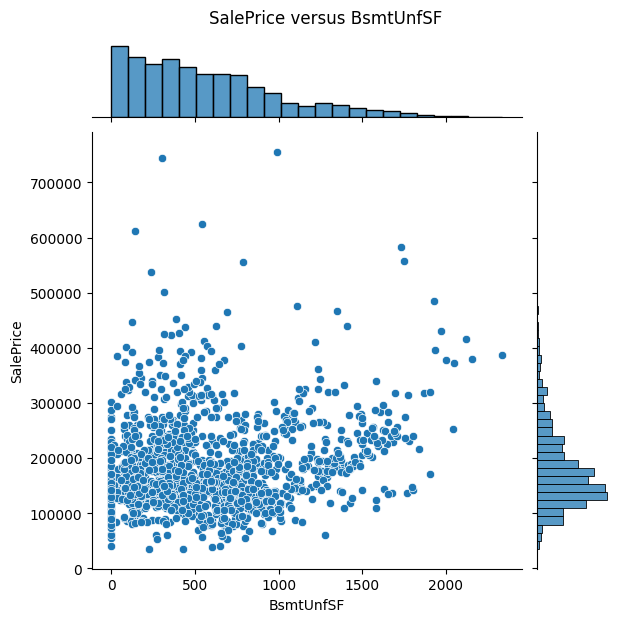

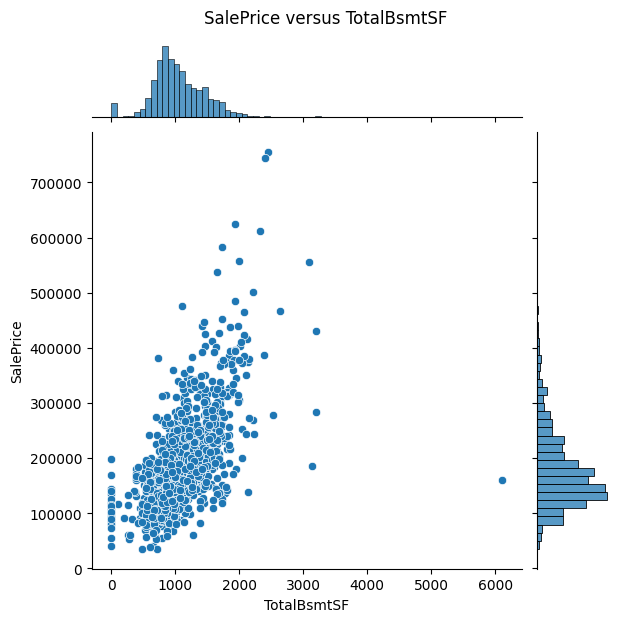

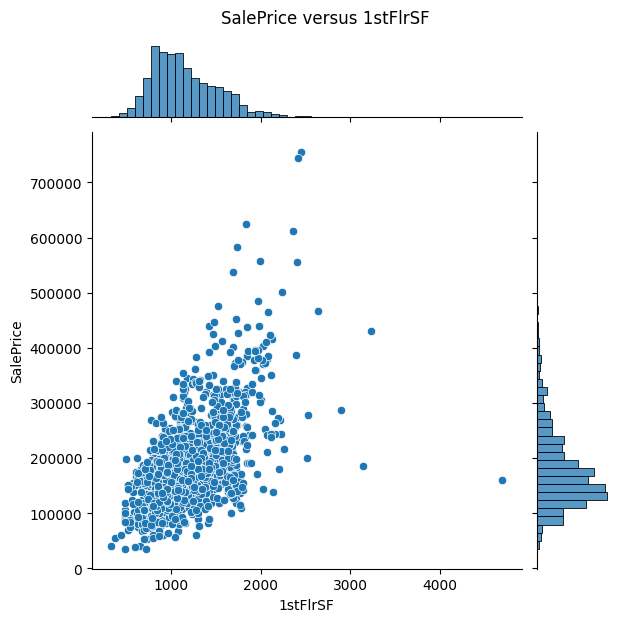

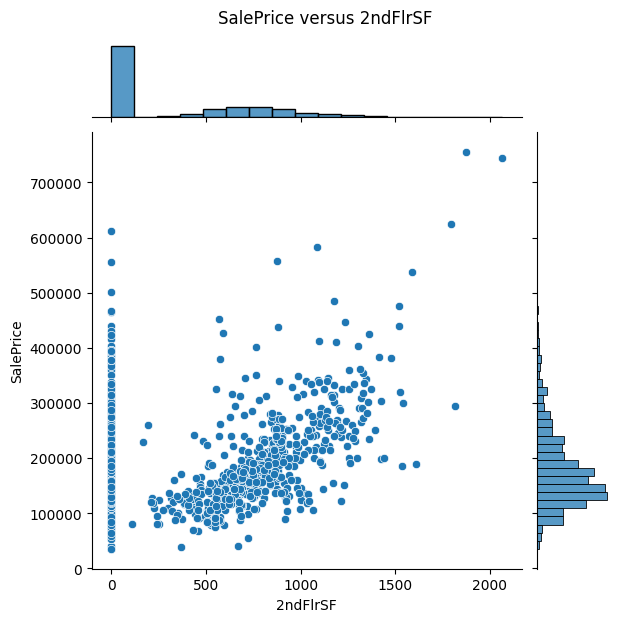

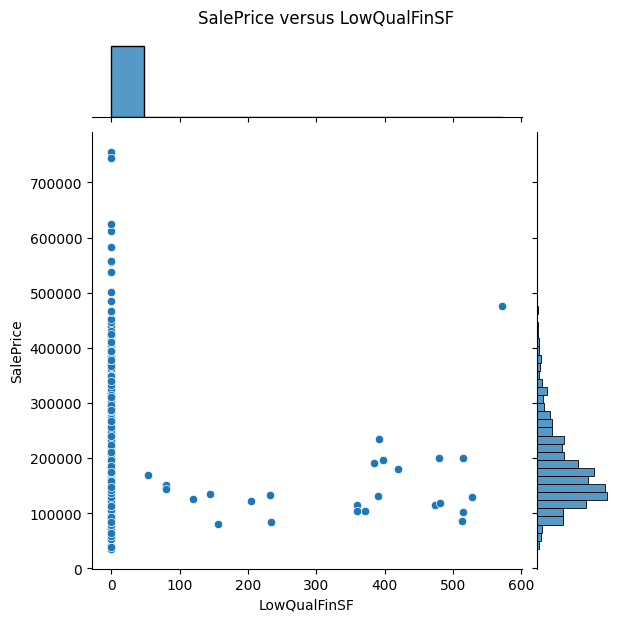

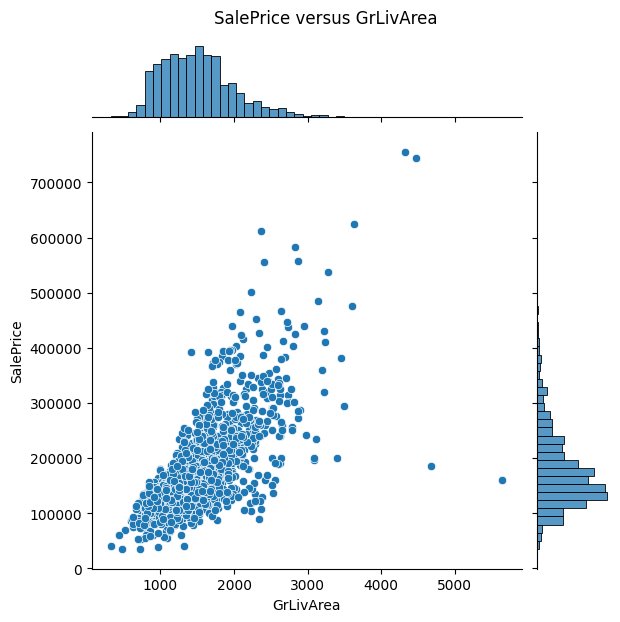

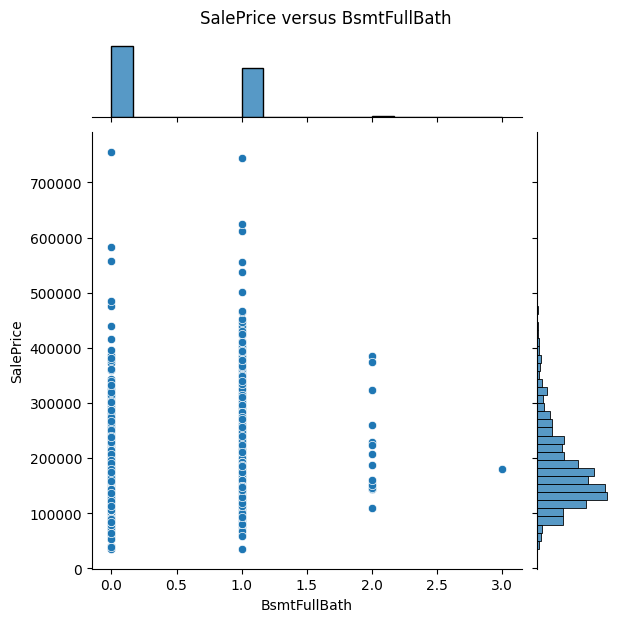

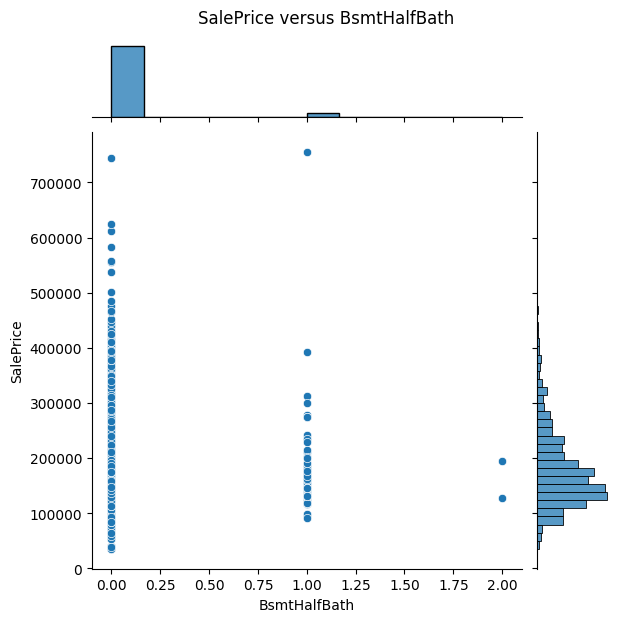

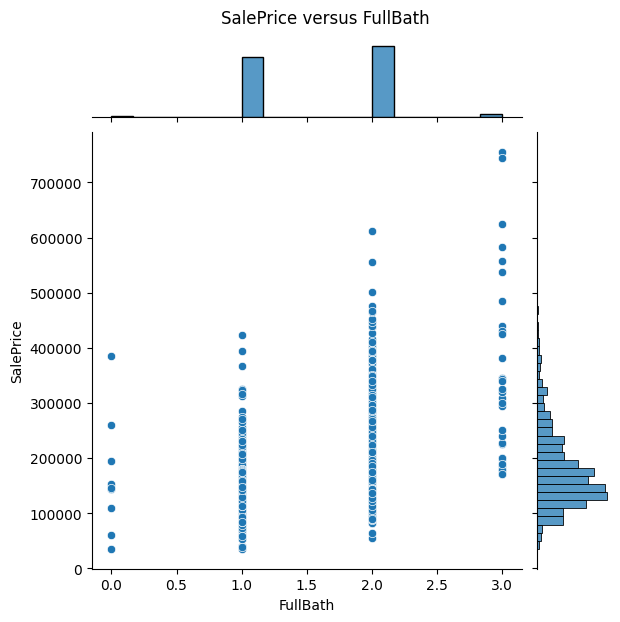

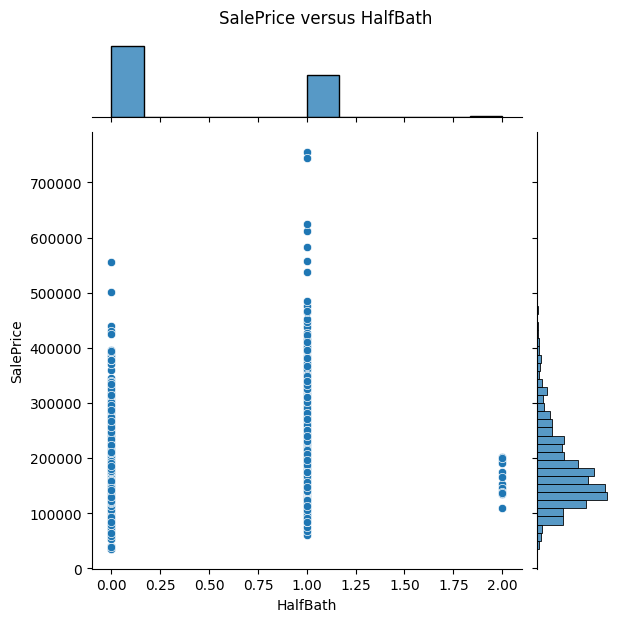

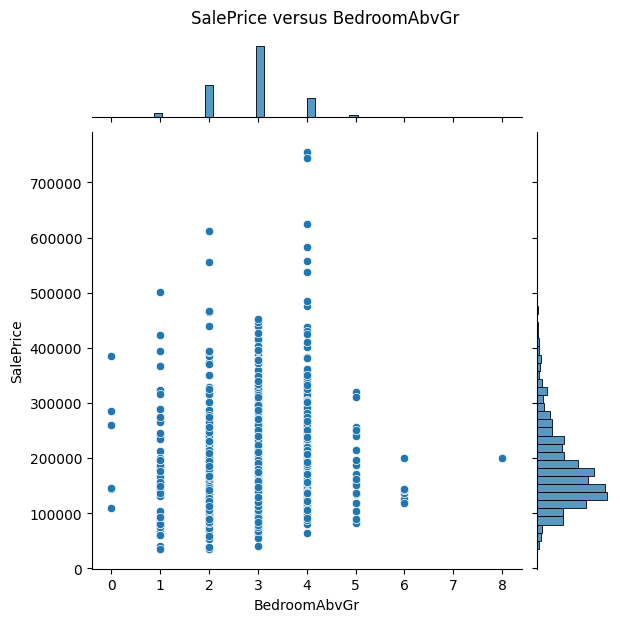

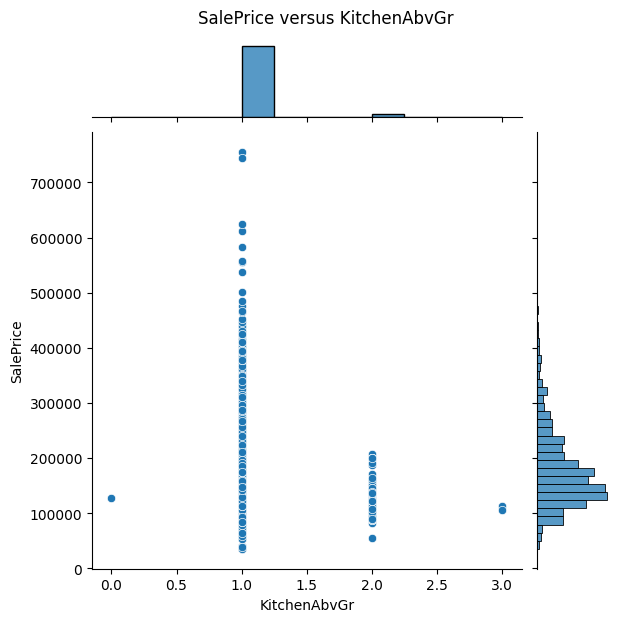

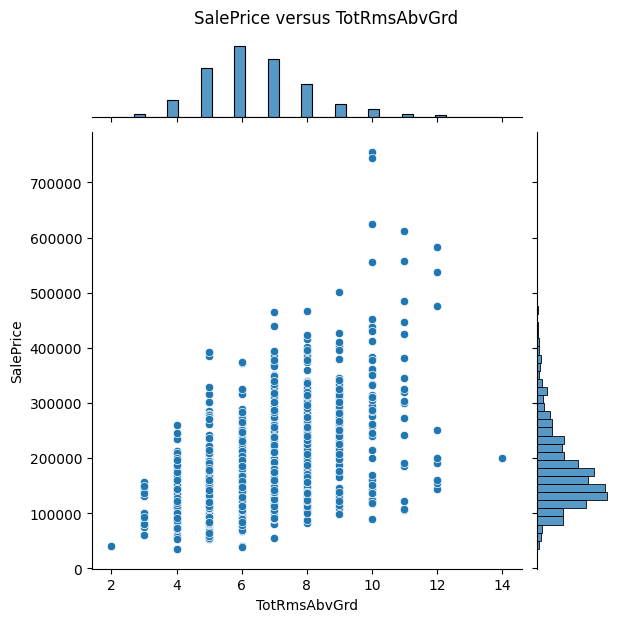

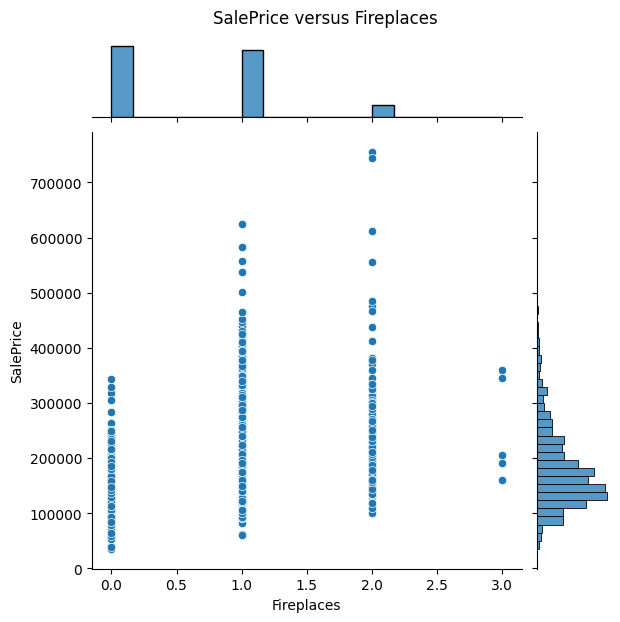

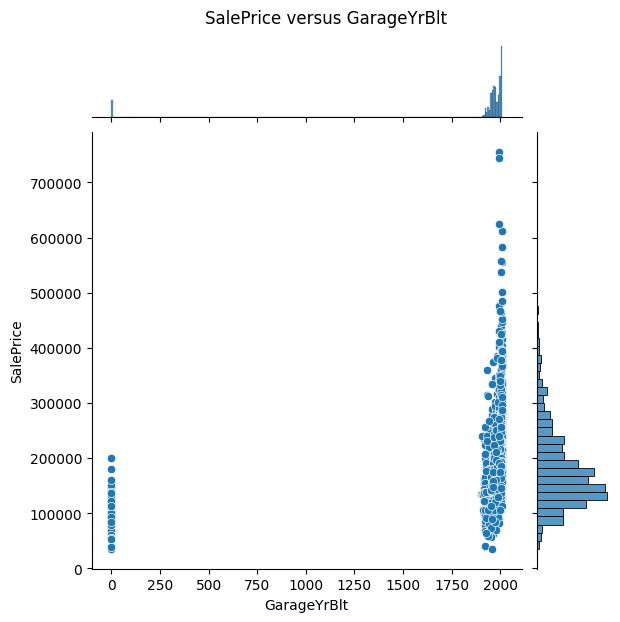

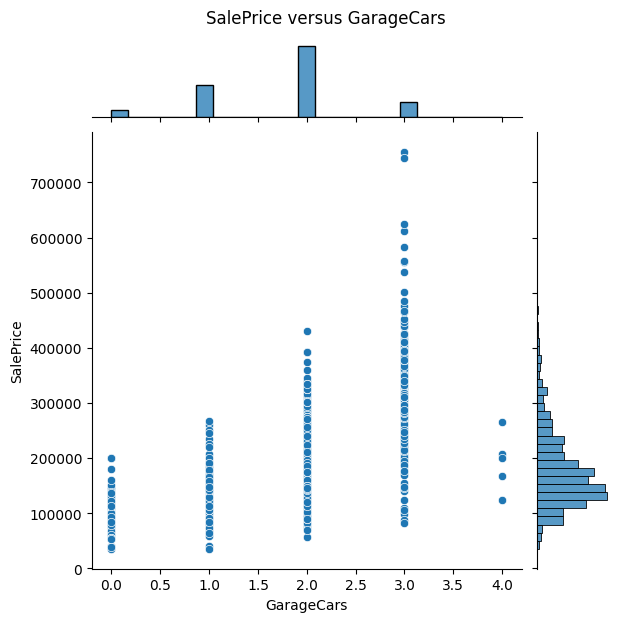

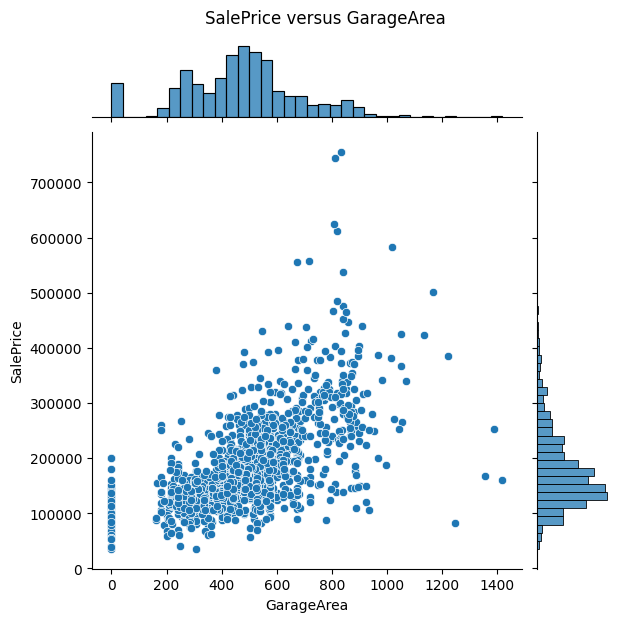

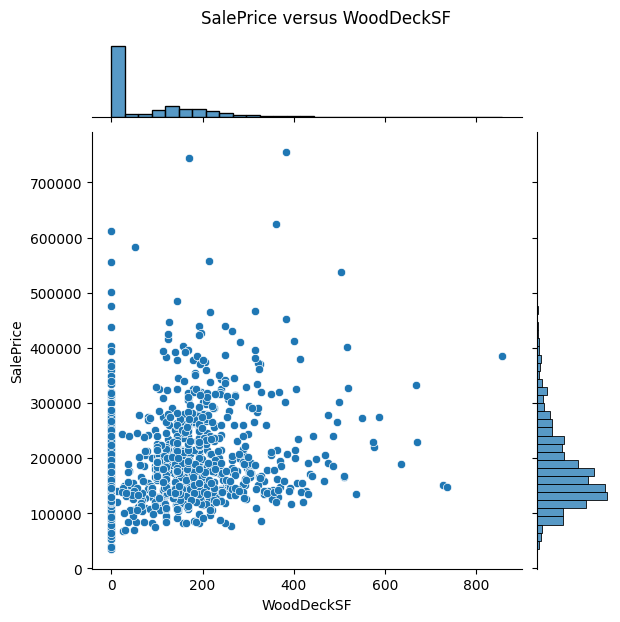

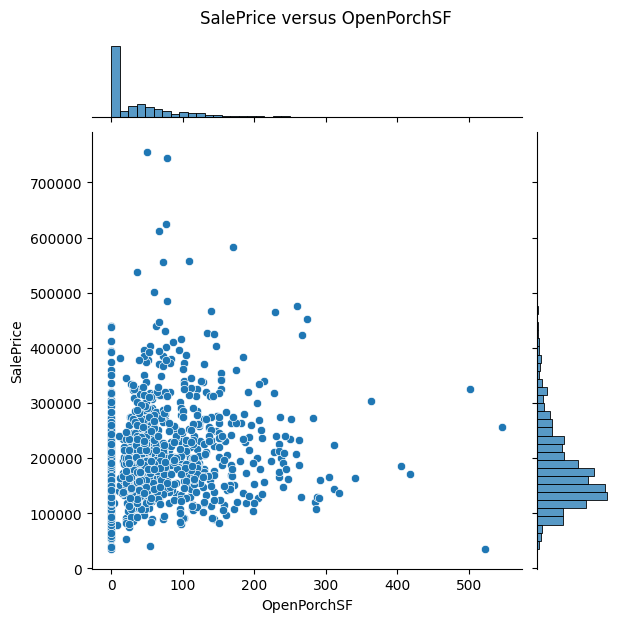

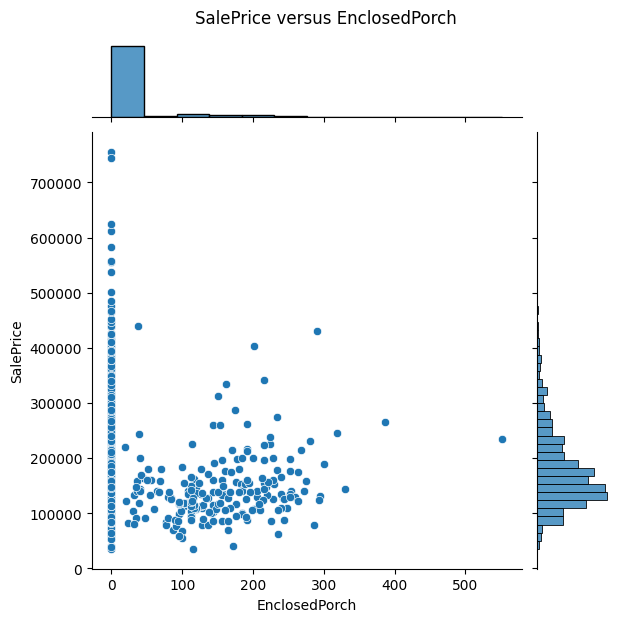

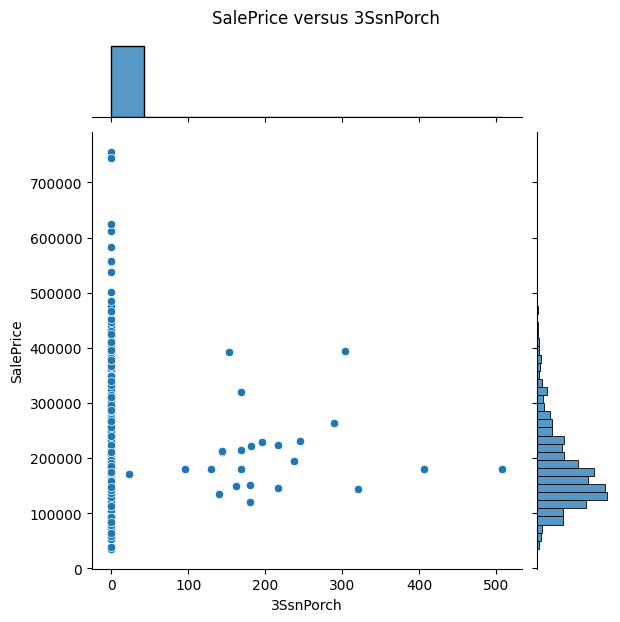

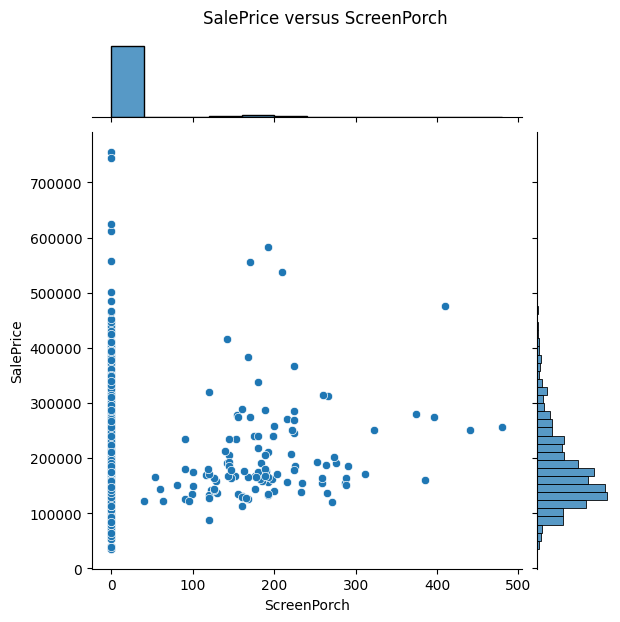

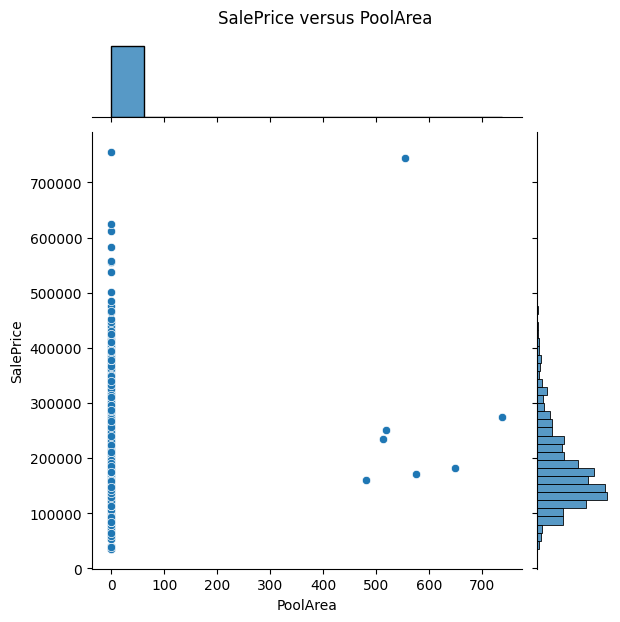

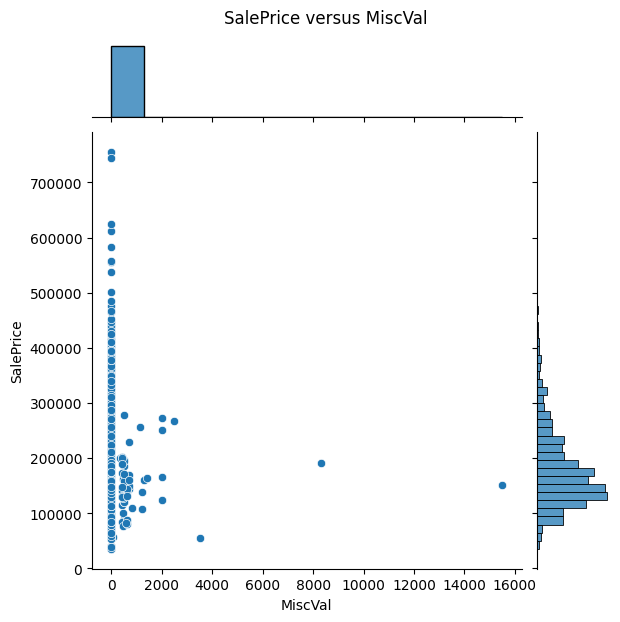

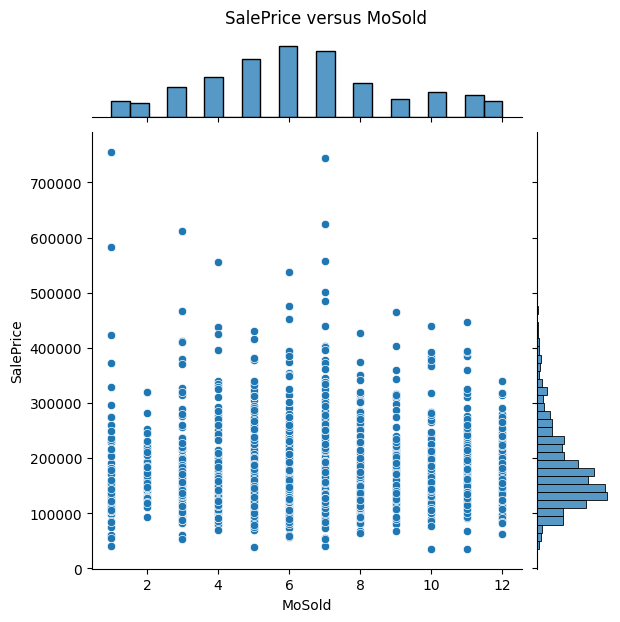

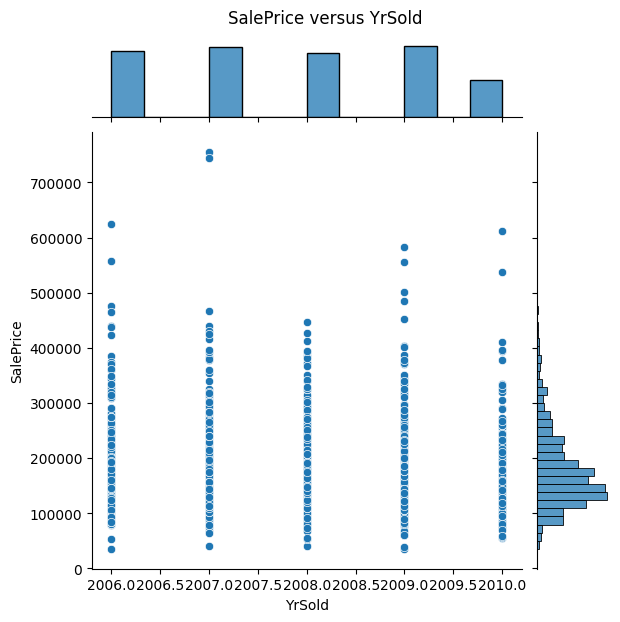

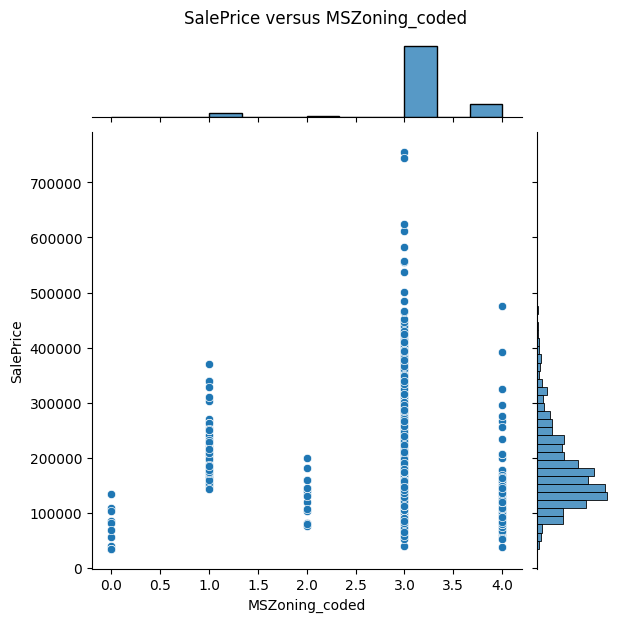

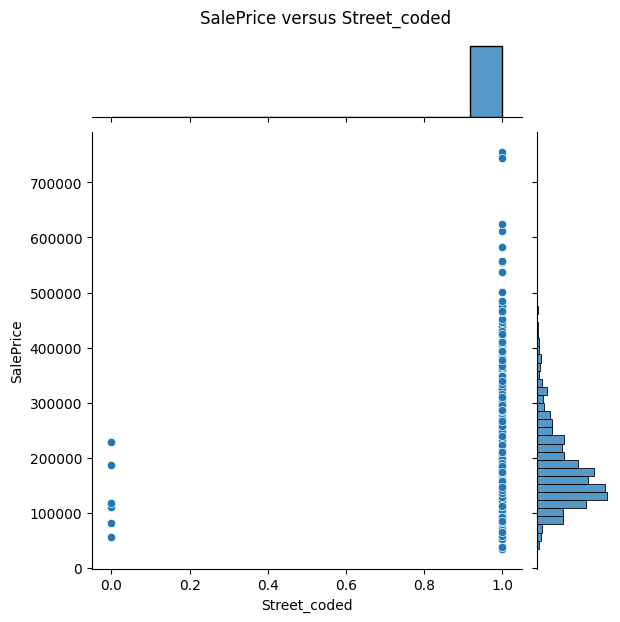

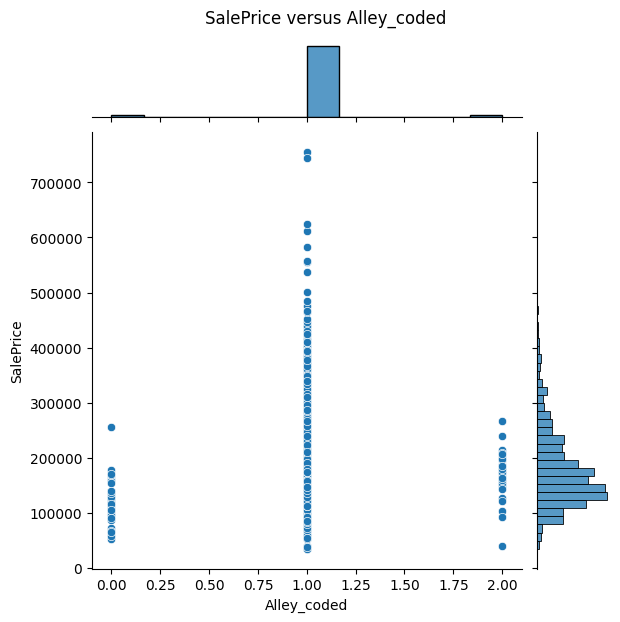

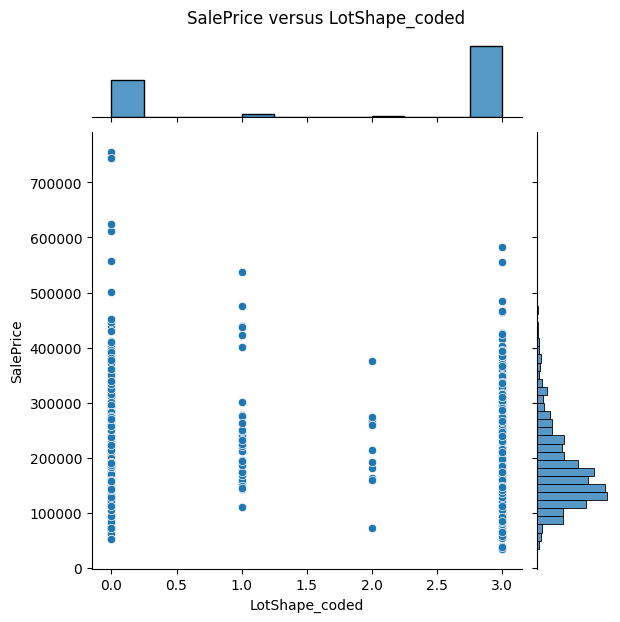

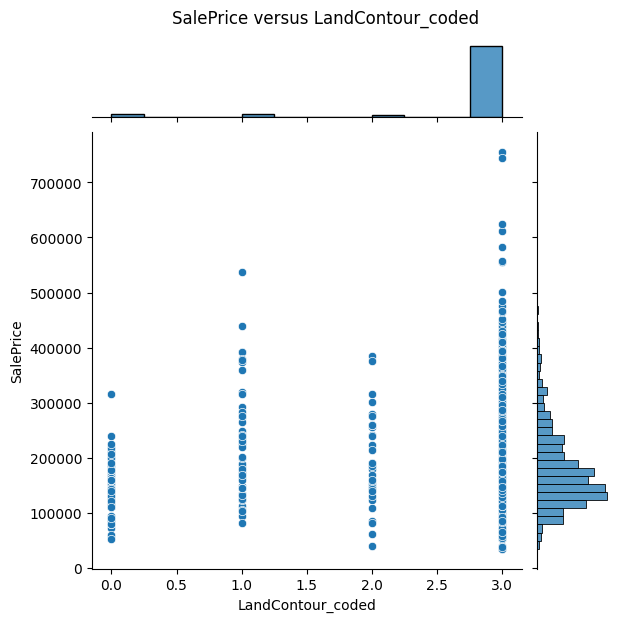

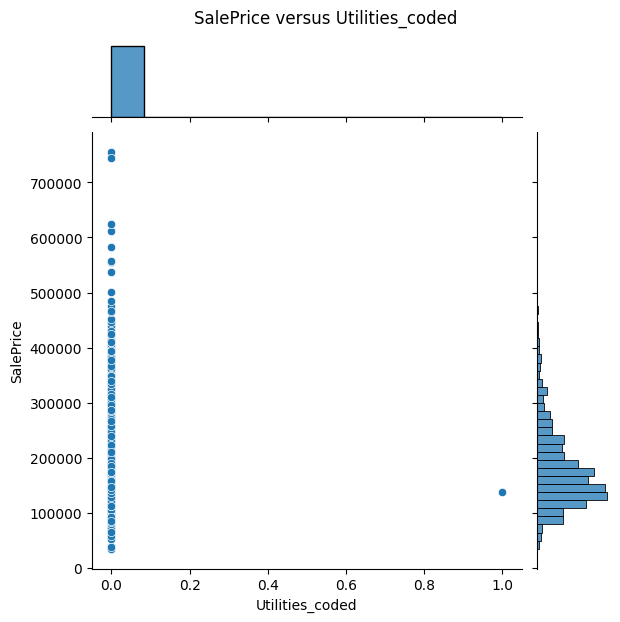

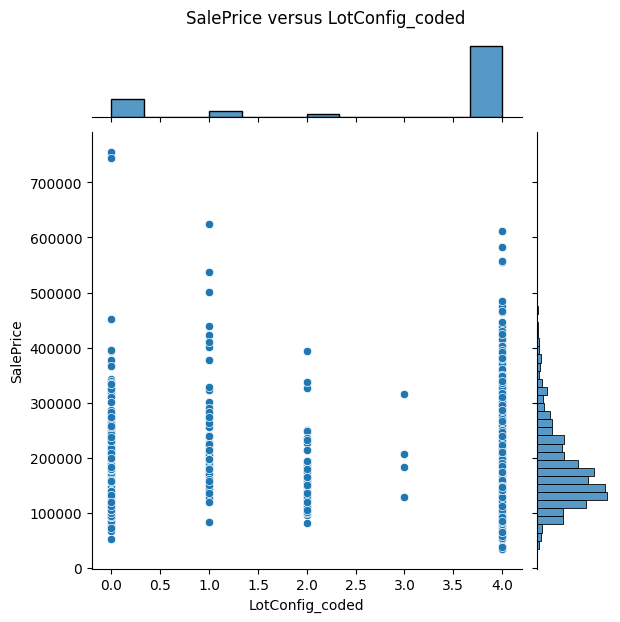

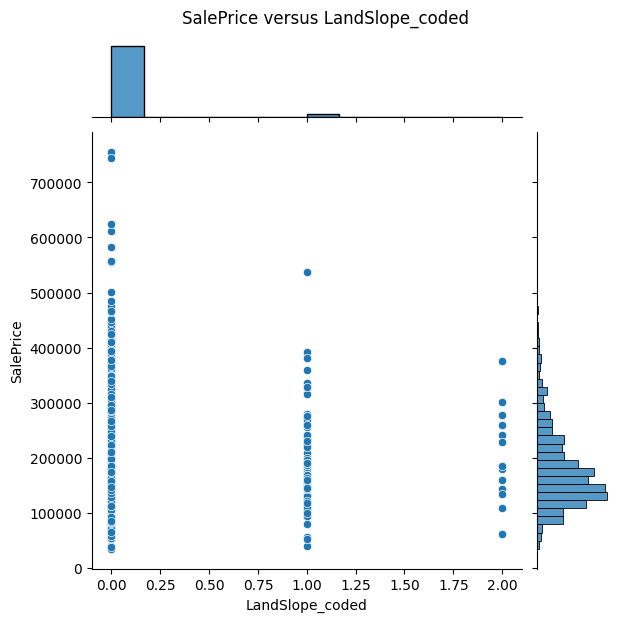

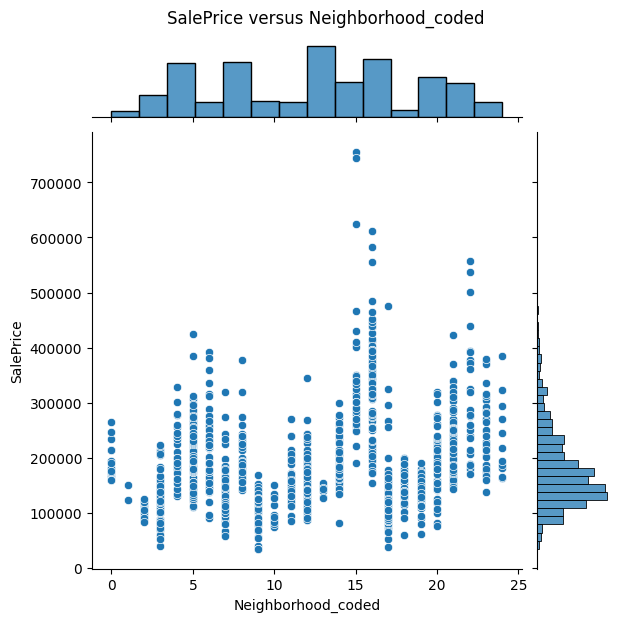

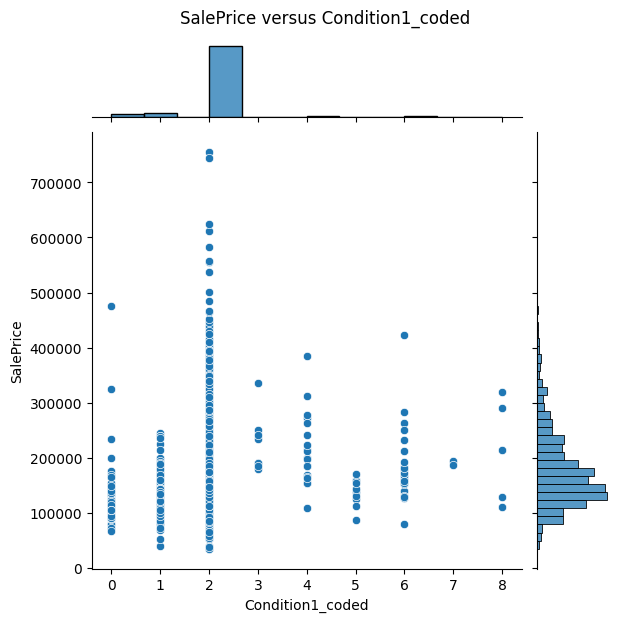

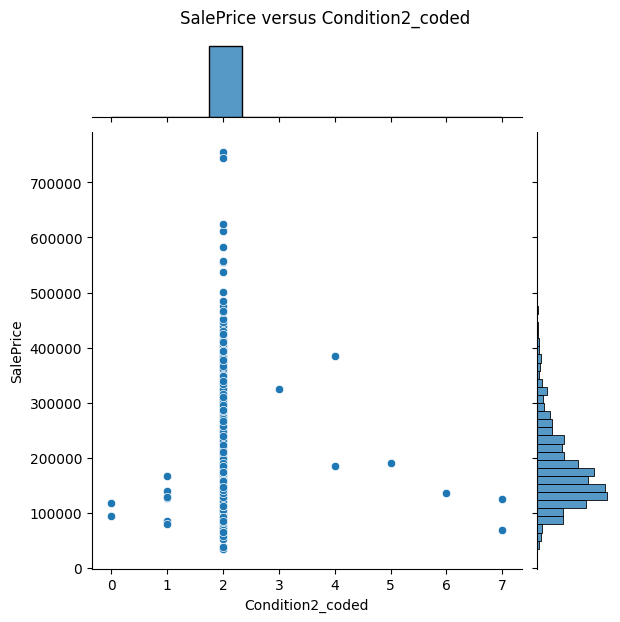

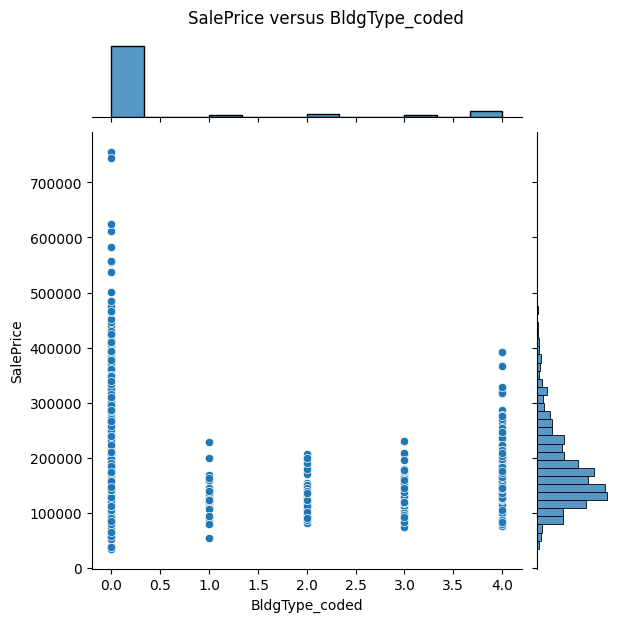

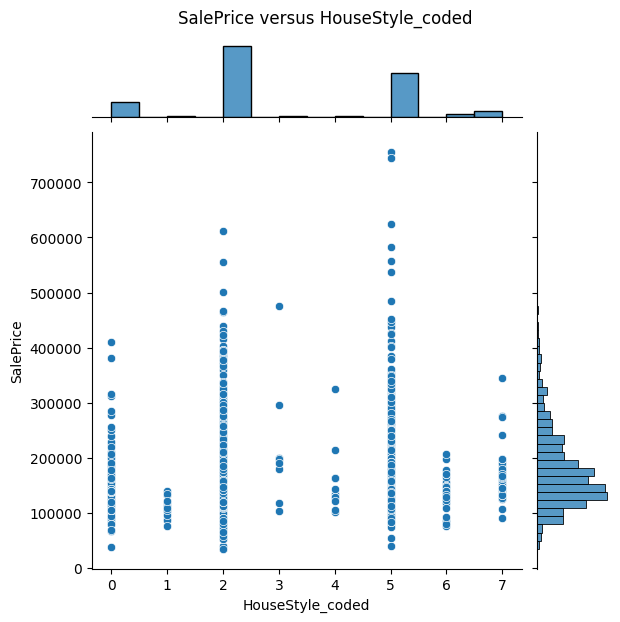

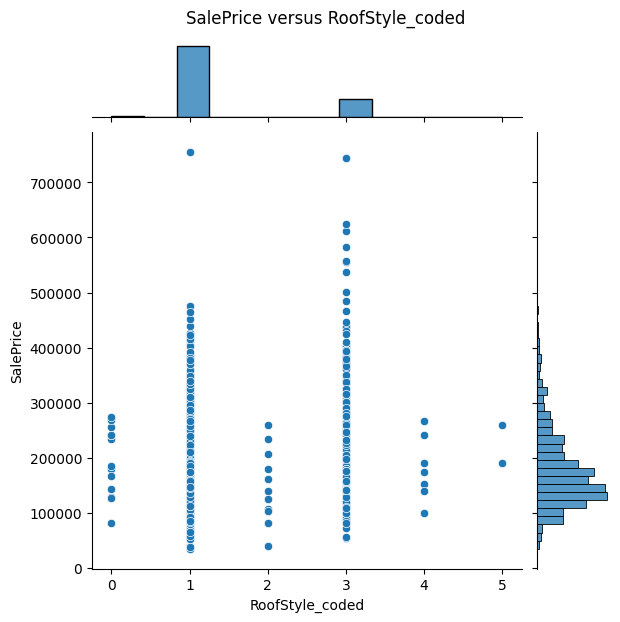

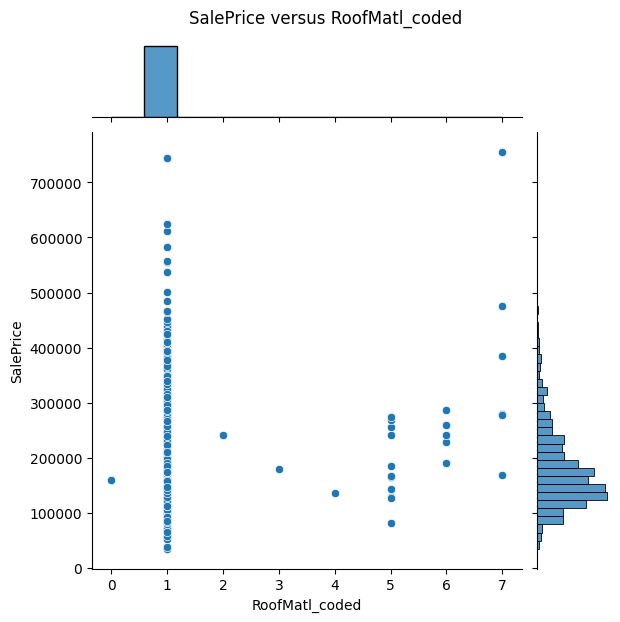

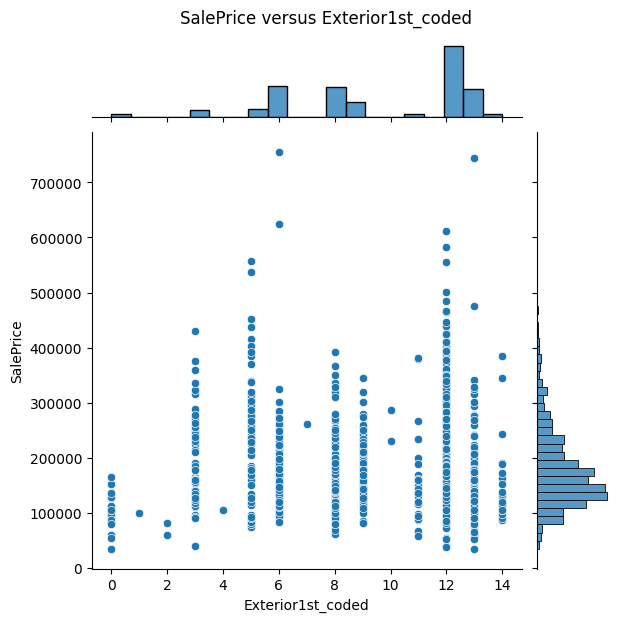

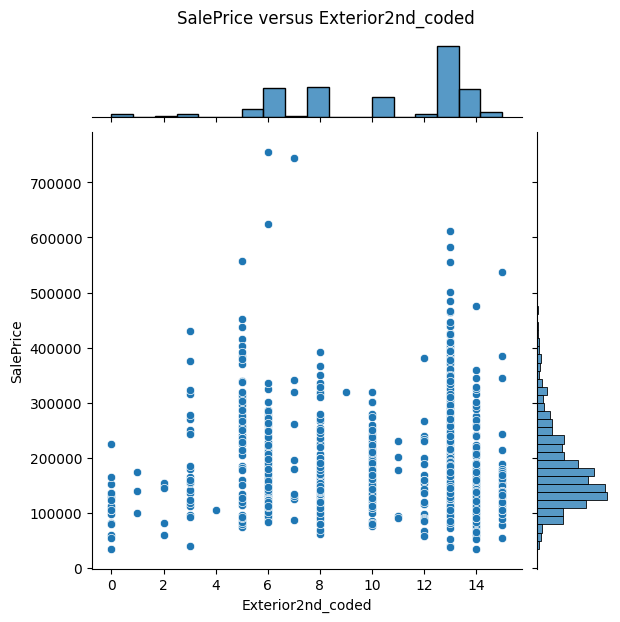

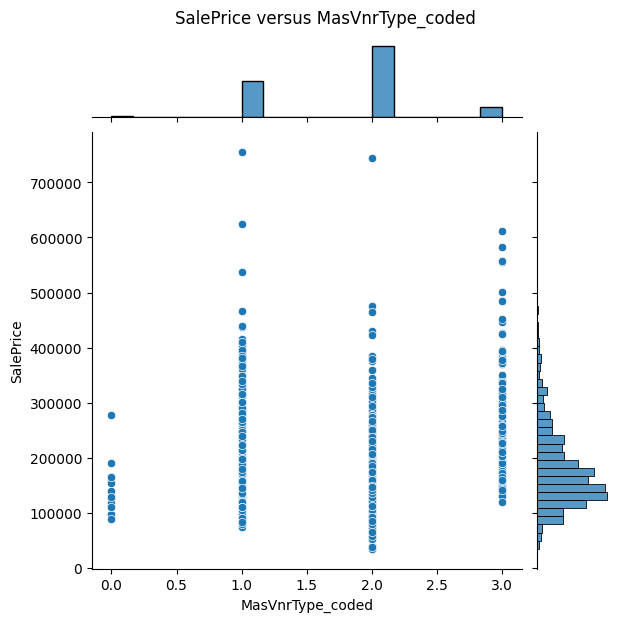

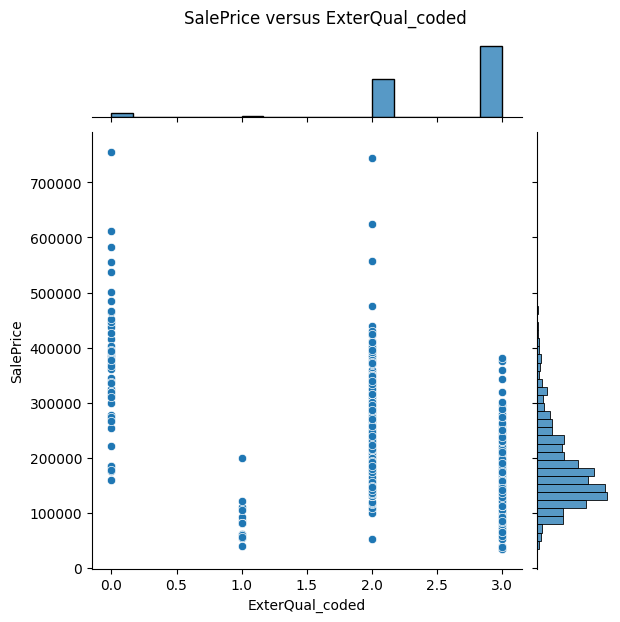

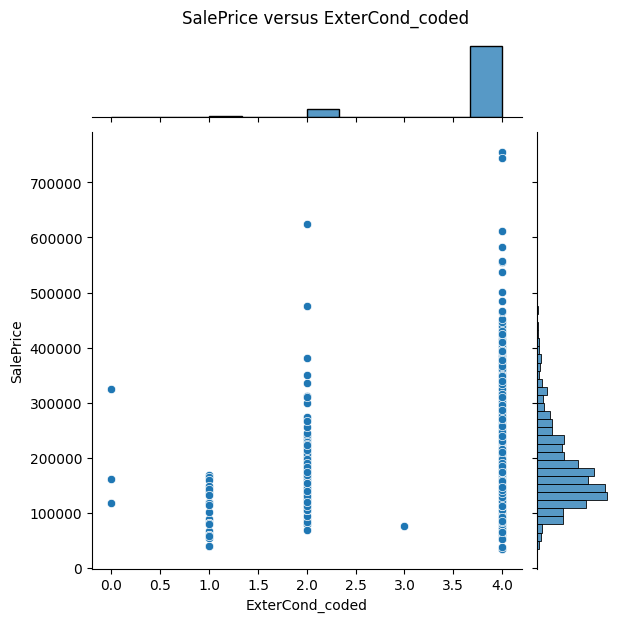

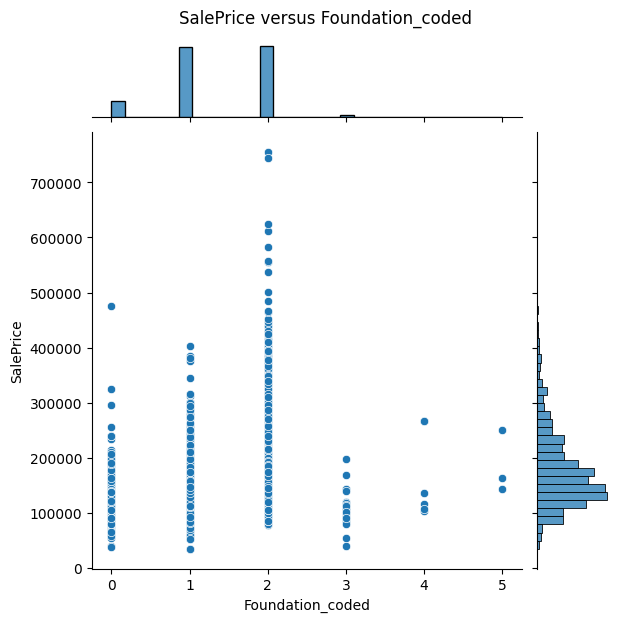

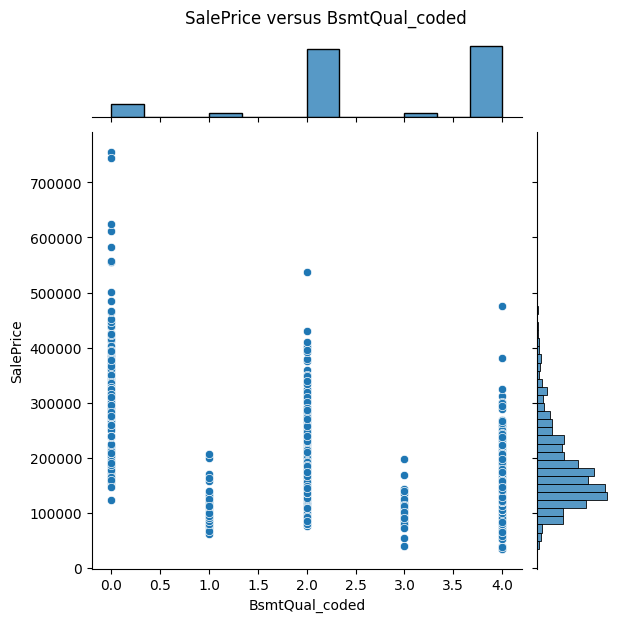

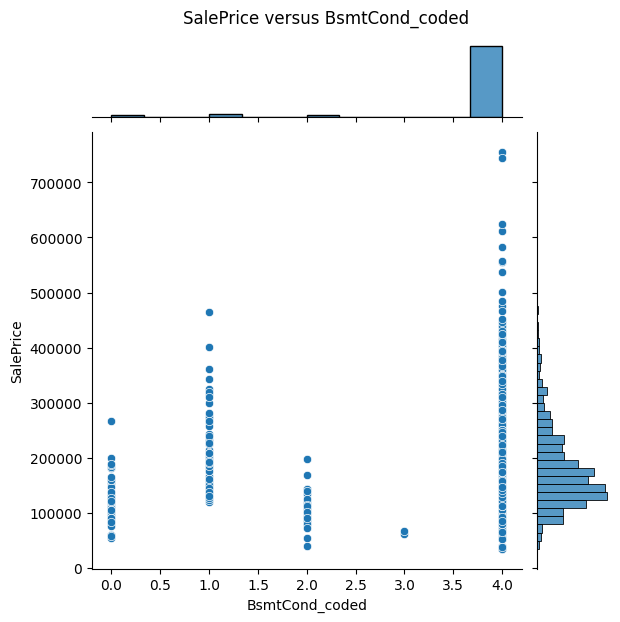

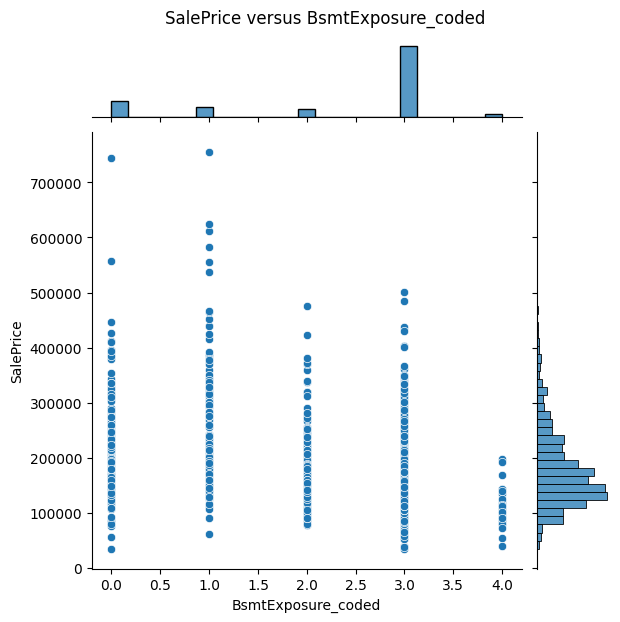

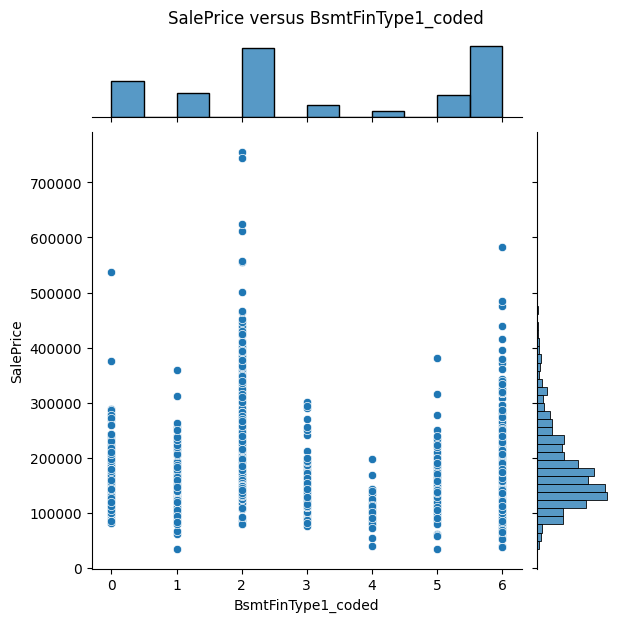

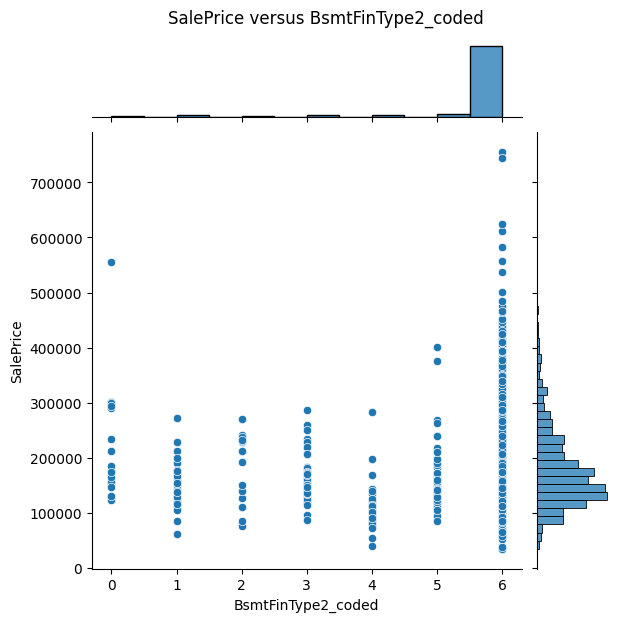

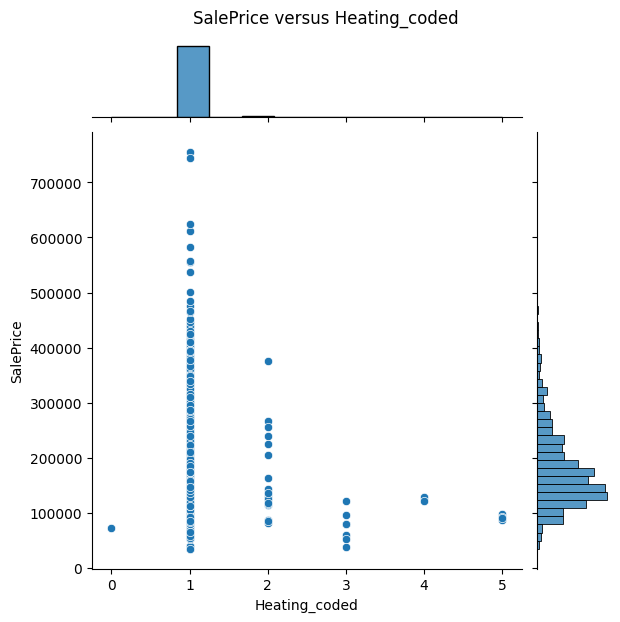

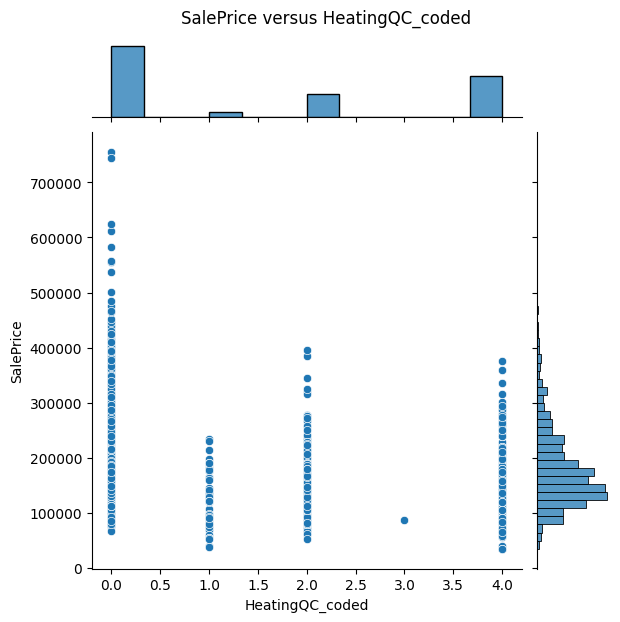

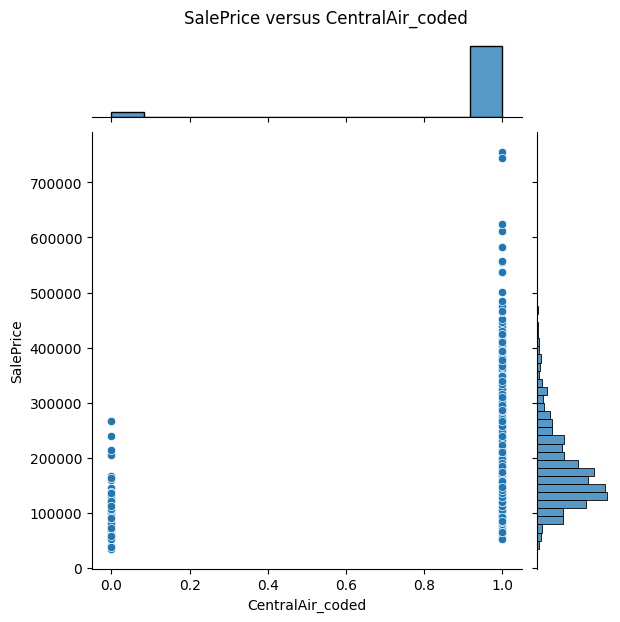

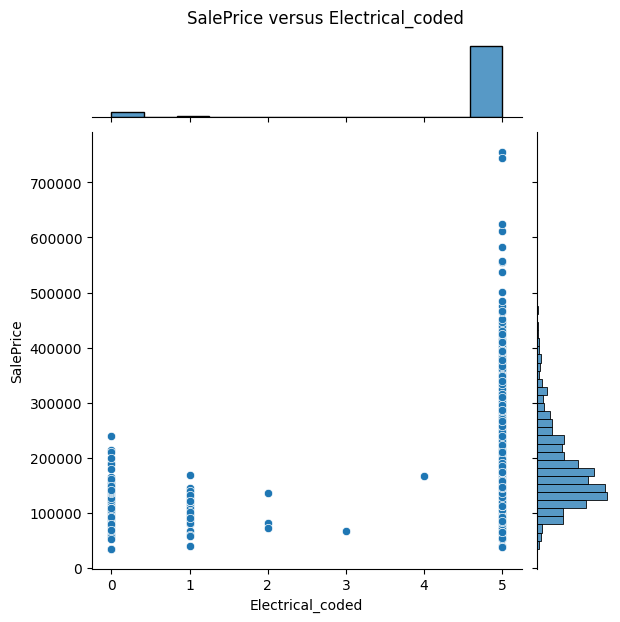

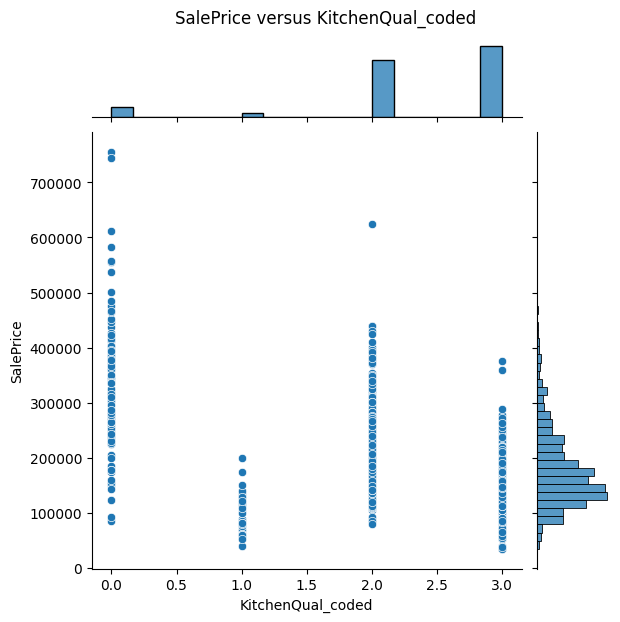

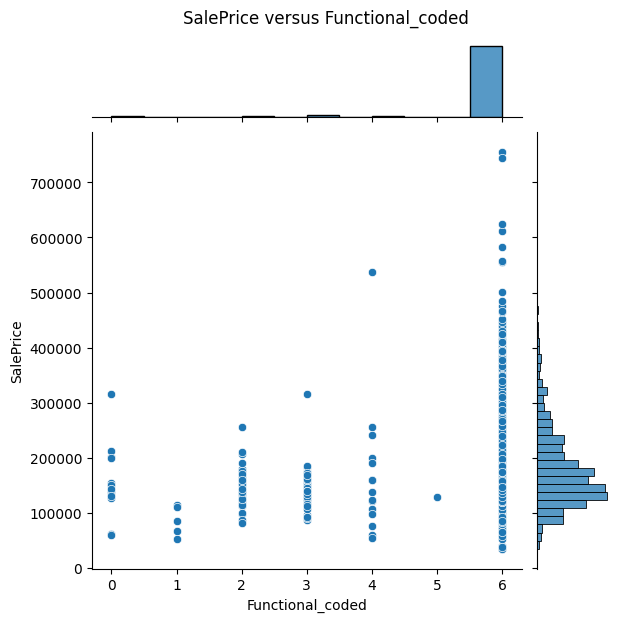

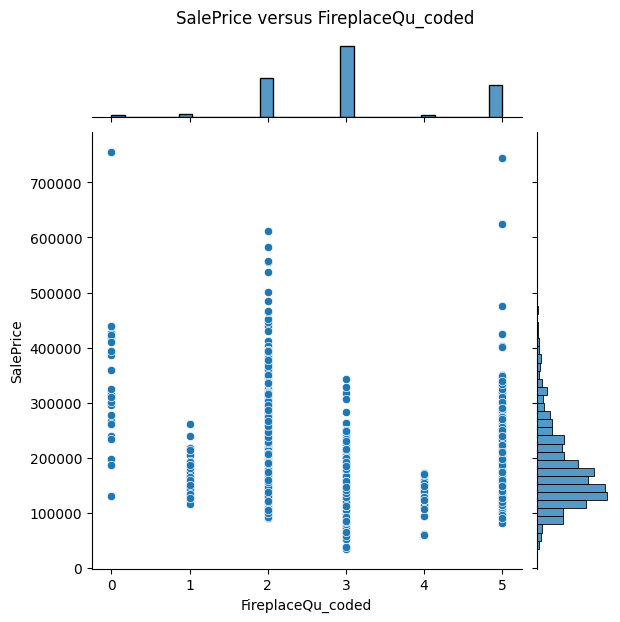

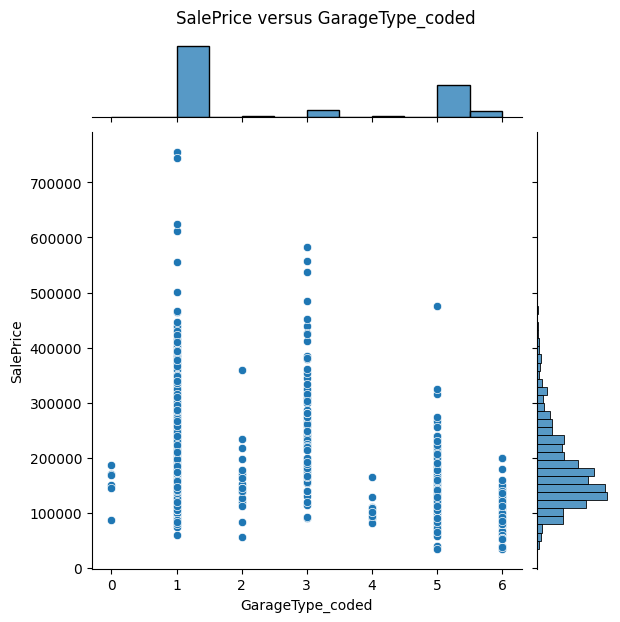

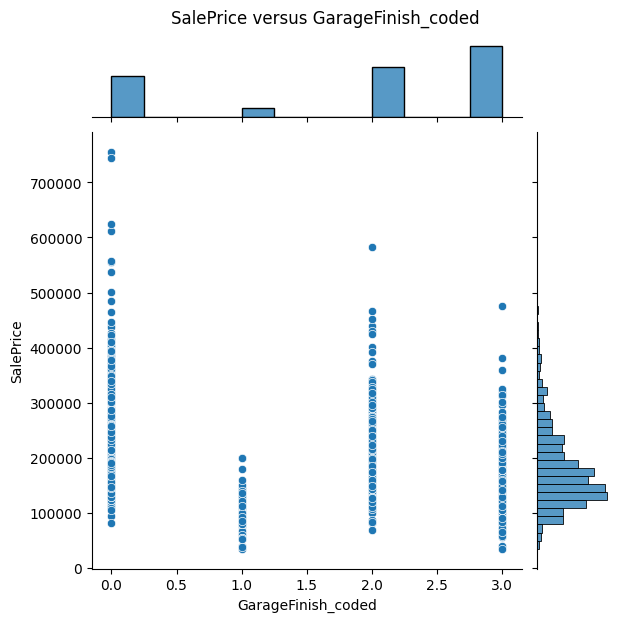

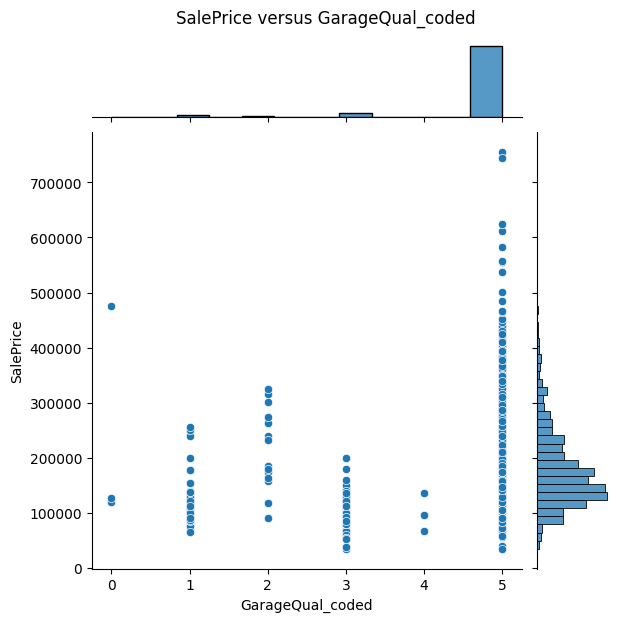

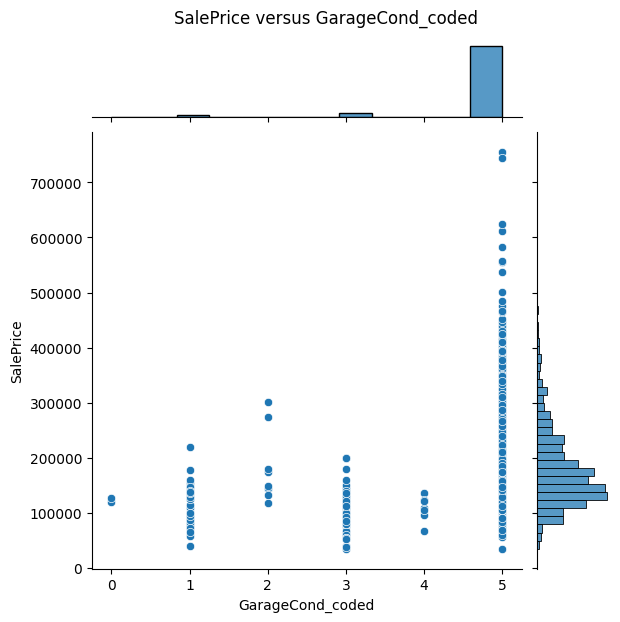

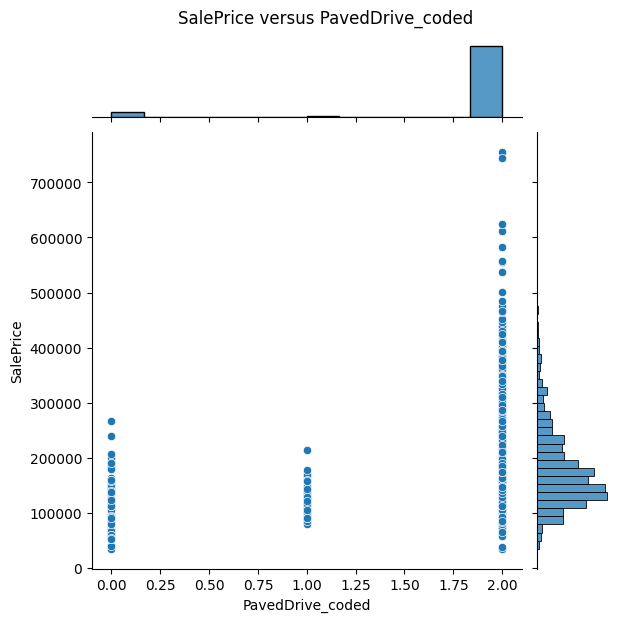

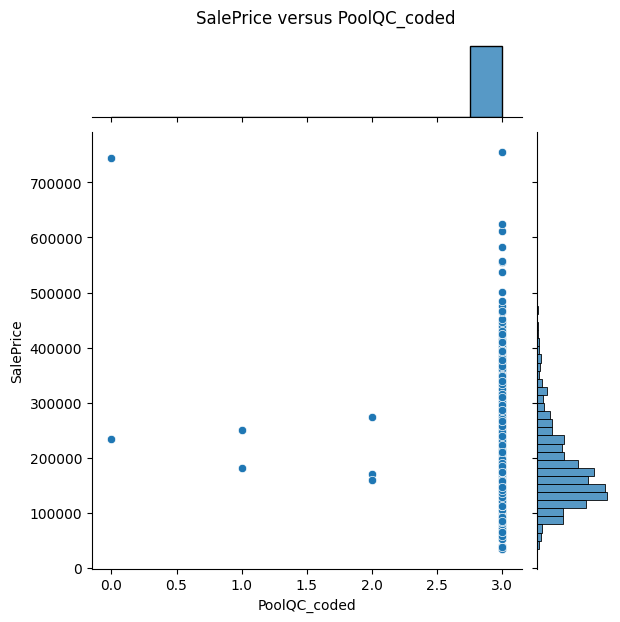

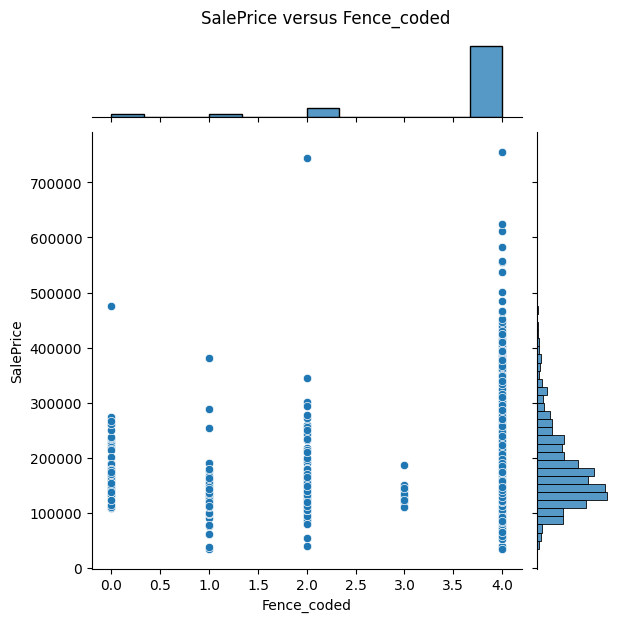

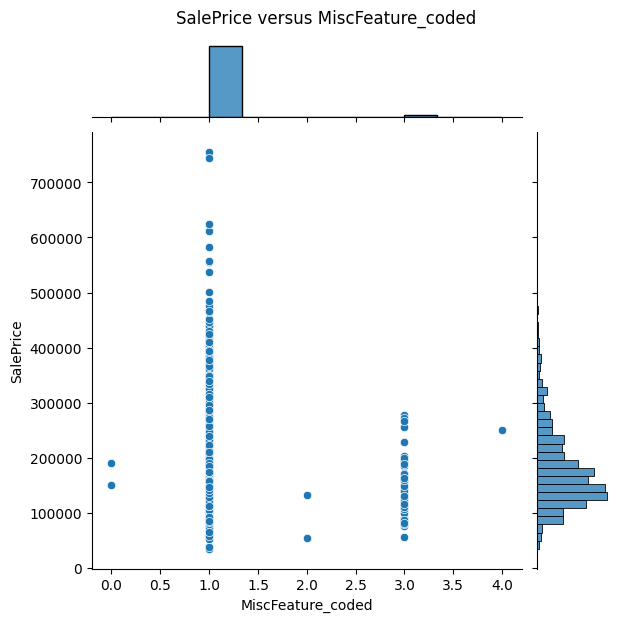

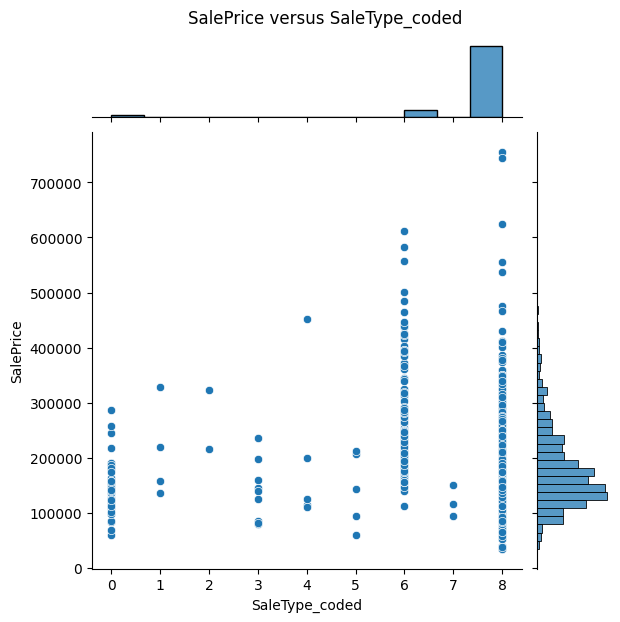

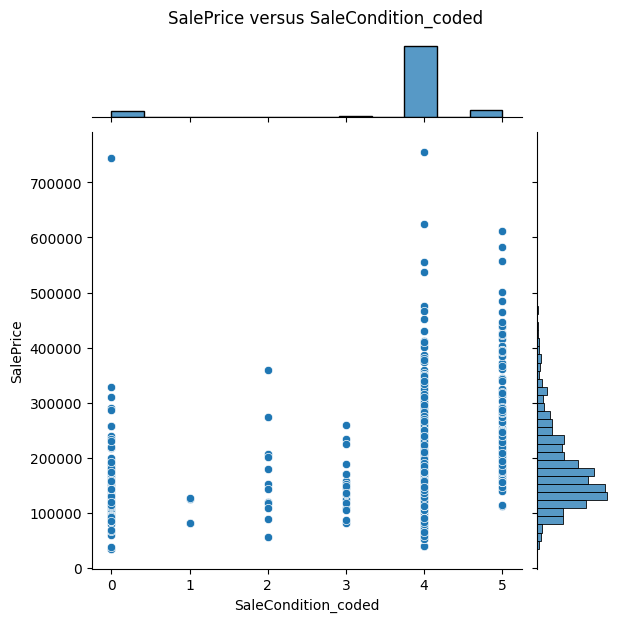

In [25]:
# individual plots i.e., sales price vs feature
feature_list = [col for col in train_df_coded.columns if col not in ["SalePrice", "Id"]]

for col in feature_list:
    g = sns.jointplot(data=train_df_coded, x=col, y="SalePrice")
    g.fig.suptitle(f"SalePrice versus {col}", y=1.03)
    plt.show()


Summary statistics of Sales price:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


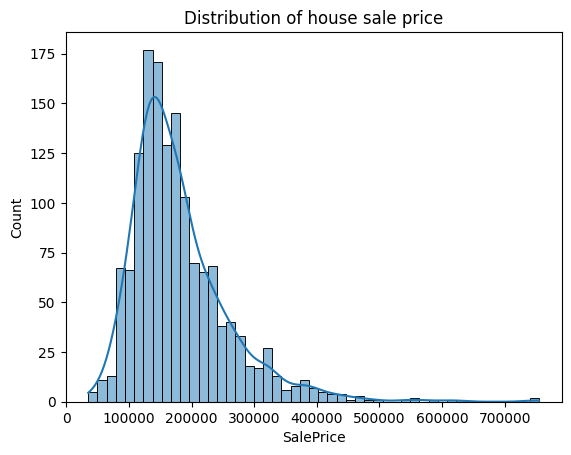

In [26]:
#Vizualizing and understanding the target

sns.histplot(data=train_df, x="SalePrice", kde=True)
plt.title("Distribution of house sale price")

print("\nSummary statistics of Sales price:")
print(train_df["SalePrice"].describe())


In [27]:
# Identifying outliers in each feature

data_for_outliers = train_df[integer_columns].copy()

outliers_index_df = pd.DataFrame()

for i in data_for_outliers.columns:
    Q1 = data_for_outliers[i].quantile(0.25)
    Q3 = data_for_outliers[i].quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5
    
    x = train_df[(data_for_outliers[i] < Q1 - threshold * IQR) | (data_for_outliers[i] > Q3 + threshold * IQR)]
    outliers_index_df [i] = pd.Series(x.index)

print("\nThe number of outliers identified in each column:\n")
print(outliers_index_df.count())



The number of outliers identified in each column:

MSSubClass       103
LotFrontage       16
LotArea           69
OverallQual        2
OverallCond      103
YearBuilt          7
YearRemodAdd       0
MasVnrArea        98
BsmtFinSF1         7
BsmtFinSF2       103
BsmtUnfSF         29
TotalBsmtSF       61
1stFlrSF          20
2ndFlrSF           2
LowQualFinSF      26
GrLivArea         31
BsmtFullBath       1
BsmtHalfBath      82
FullBath           0
HalfBath           0
BedroomAbvGr      35
KitchenAbvGr      68
TotRmsAbvGrd      30
Fireplaces         5
GarageYrBlt       81
GarageCars         5
GarageArea        21
WoodDeckSF        32
OpenPorchSF       77
EnclosedPorch    103
3SsnPorch         24
ScreenPorch      103
PoolArea           7
MiscVal           52
MoSold             0
YrSold             0
SalePrice         61
dtype: int64


In [28]:
# Onehotencoding for categorical columns and scalarizing integer columns
train_df_categorical = train_df[categorical_columns].copy()

train_df_int = train_df[integer_columns_without_target].copy()

scaler = StandardScaler()

onehot_encoder = OneHotEncoder(sparse=False, drop='first')

scaled_data = scaler.fit_transform(train_df_int)

onehot_encoded_data = onehot_encoder.fit_transform(train_df_categorical)

train_df_scalarized = pd.DataFrame(scaled_data, columns=scaler.get_feature_names_out(integer_columns_without_target))

train_df_categorical_onehot_encoded = pd.DataFrame(onehot_encoded_data, columns=onehot_encoder.get_feature_names_out(categorical_columns))

train_df_onehot_encoded_scalarized = pd.concat([train_df_scalarized, train_df_categorical_onehot_encoded], axis=1)

train_df_onehot_encoded = pd.concat([train_df_int, train_df_categorical_onehot_encoded], axis=1)


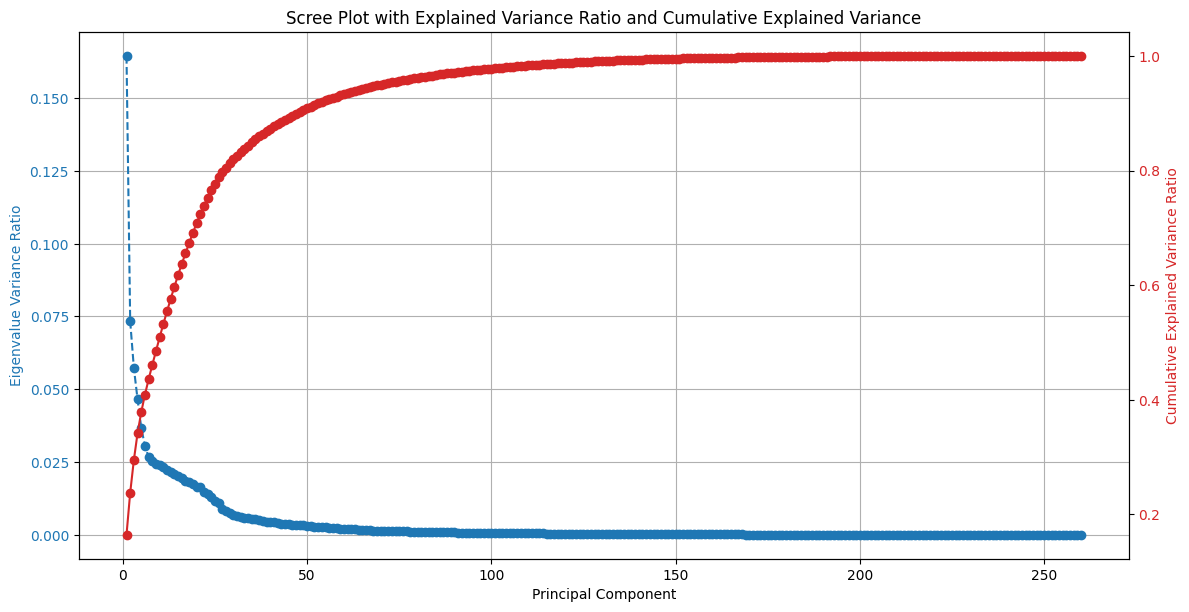

'\nThe highest eigen value ratio is 15% suggesting that there are no strong underlying patters in the input feature.\nFeature data is spread out and possibly complex.\n'

In [29]:
# Principal component analysis (PCA)
pca = PCA()

pca.fit_transform(train_df_onehot_encoded_scalarized)

explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue Variance Ratio', color=color)
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color=color, label='Explained Variance Ratio')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Cumulative Explained Variance Ratio', color=color)
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color=color, label='Cumulative Explained Variance Ratio')
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(True)
fig.tight_layout()
plt.title('Scree Plot with Explained Variance Ratio and Cumulative Explained Variance')

plt.show()

'''
The highest eigen value ratio is 15% suggesting that there are no strong underlying patters in the input feature.
Feature data is spread out and possibly complex.
'''

In [30]:
#Training a xgb model

X = train_df_onehot_encoded.copy()

y = train_df["SalePrice"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = xgb.XGBRegressor(n_estimators=500,
                                 learning_rate=0.1,
                                 objective='reg:squarederror')

xgb_regressor.fit(X_train, y_train)

R2 = xgb_regressor.score(X_test,y_test)

print(f"\nInitial model accuracy (R_square): {R2}")


Initial model accuracy (R_square): 0.9078314790032544


In [31]:
# Feature importance

feature_importance = xgb_regressor.feature_importances_

feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature importance:")
print(importance_df.to_string())


Feature importance:
                        Feature    Importance
3                   OverallQual  3.415141e-01
25                   GarageCars  7.637384e-02
15                    GrLivArea  4.469007e-02
195                CentralAir_Y  2.878113e-02
21                 KitchenAbvGr  2.652233e-02
219           GarageType_Detchd  2.277354e-02
62         Neighborhood_Edwards  1.734243e-02
209              Functional_Typ  1.702148e-02
175            BsmtFinType1_GLQ  1.663008e-02
22                 TotRmsAbvGrd  1.507920e-02
11                  TotalBsmtSF  1.429673e-02
18                     FullBath  1.364209e-02
163                 BsmtQual_Gd  1.331065e-02
12                     1stFlrSF  1.298773e-02
59         Neighborhood_ClearCr  1.298591e-02
39                  MSZoning_RM  1.281265e-02
32                     PoolArea  1.206291e-02
13                     2ndFlrSF  1.155211e-02
202              KitchenQual_Gd  1.129713e-02
228               GarageQual_TA  1.126231e-02
44           

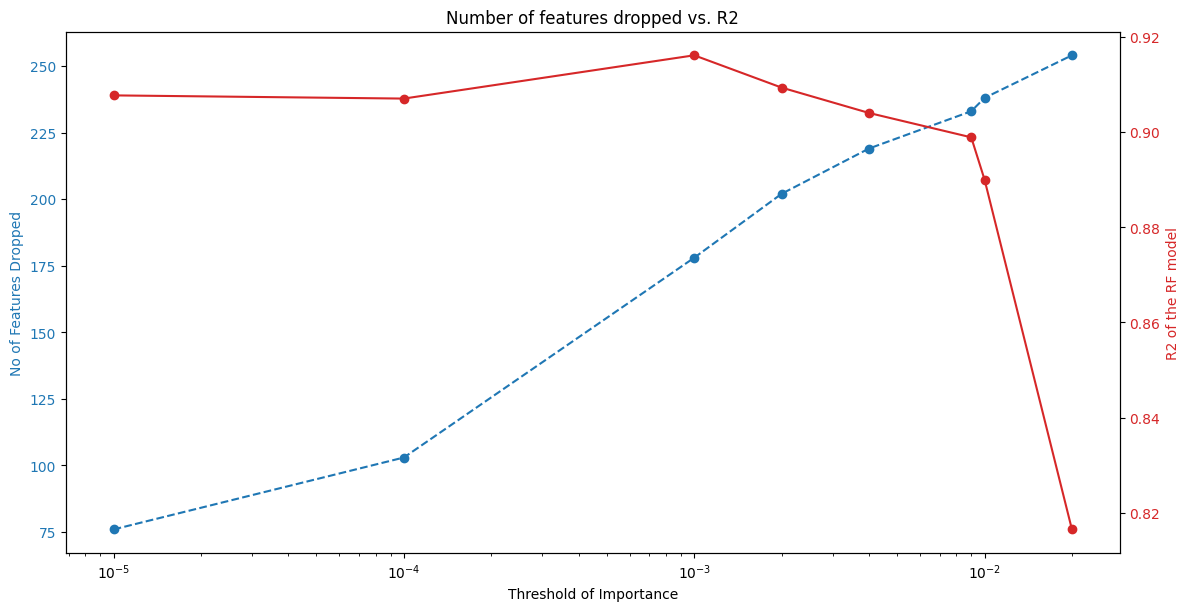

In [32]:
'''
Identifying ideal threshold/s to drop features below an inportance value and retraining the model
'''

Feature_selection_df = pd.DataFrame(columns = ["Threshold", "No_of_features_dropped", "R2"])

Feature_selection_df = Feature_selection_df.astype({"Threshold": "float", "No_of_features_dropped": "int", "R2": "float"})

threshold_values = [10**-5, 10**-4, 10**-3, 2 * 10**-3, 4 * 10**-3, 9 * 10**-3, 10**-2, 2 * 10**-2]

Feature_selection_df["Threshold"] = threshold_values

for threshold in threshold_values:
    
    features_with_low_importance = [col for col in importance_df["Feature"] if importance_df.loc[importance_df["Feature"] == col, "Importance"].values[0] <= threshold]
    
    Feature_selection_df.loc[Feature_selection_df["Threshold"]==threshold,"No_of_features_dropped"] = len(features_with_low_importance)

    # Fitting a model after dropping features
    
    X_modified = train_df_onehot_encoded.copy()
    
    y = train_df["SalePrice"].copy()
    
    X_modified.drop(columns = features_with_low_importance, inplace = True)
    
    X_modified_train, X_modified_test, y_train, y_test = train_test_split(X_modified, y, test_size=0.2, random_state=42)
    
    xgb_regressor.fit(X_modified_train, y_train)
    
    Feature_selection_df.loc[Feature_selection_df["Threshold"]==threshold,"R2"] = xgb_regressor.score(X_modified_test,y_test)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Threshold of Importance')
ax1.set_ylabel('No of Features Dropped', color=color)
ax1.plot(Feature_selection_df["Threshold"], Feature_selection_df["No_of_features_dropped"], marker='o', linestyle='--', color=color, label='Number of features dropped')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('R2 of the RF model', color=color)
ax2.plot(Feature_selection_df["Threshold"], Feature_selection_df["R2"], marker='o', linestyle='-', color=color, label='R2')
ax2.tick_params(axis='y', labelcolor=color)

plt.xscale('log')
fig.tight_layout()
plt.title('Number of features dropped vs. R2')

plt.show()

In [33]:
'''
Looking at the threshold vs. R2 graph, 0.001, 0.002, 0.003 and 0.004 can be a good choice of threshold as the R2 is stable upto 0.004 
without dropping too many features. Need to evaluate if better accuracy can be achieved through hyperparameter tuning while 
retaining more features i.e., by using thresholds of 0.002 or 0.001.
'''
thresholds_for_further_evaluation = [0.001, 0.002, 0.003, 0.004]
hyperparameter_dict = {}

print("\nEvaluating thresholds to drop features with hyperparameter tuning:")
for i in range(len(thresholds_for_further_evaluation)):

    # Hyperparameter tuning
    
    threshold_being_evaluated = thresholds_for_further_evaluation[i]
    
    features_dropped_from_model = [col for col in importance_df["Feature"] if importance_df.loc[importance_df["Feature"] == col, "Importance"].values[0] <= threshold_being_evaluated]
    
    print("\nThreshold {} : {}".format(i+1,thresholds_for_further_evaluation[i]))
    print("\nNumber of features dropped: {}".format(len(features_dropped_from_model)))

    X_modified = train_df_onehot_encoded.copy()
    
    y = train_df["SalePrice"].copy()
    
    X_modified.drop(columns = features_dropped_from_model, inplace = True)
    
    X_modified_train, X_modified_test, y_train, y_test = train_test_split(X_modified, y, test_size=0.2, random_state=42)
    
    model = xgb.XGBRegressor()
    
    param_grid = {'n_estimators': [100,300, 400],
                  'max_depth': [4, 5, 6, 7],
                  'learning_rate': [0.01, 0.05, 0.1],
                  'objective': ['reg:squarederror', 'reg:pseudohubererror', 'reg:absoluteerror']}
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0)
    
    grid_search.fit(X_modified_train, y_train)
    
    best_params = grid_search.best_params_
    
    hyperparameter_dict[thresholds_for_further_evaluation[i]] = best_params
    
    print("\nBest Parameters:", best_params)
    
    optimized_xgb_model = xgb.XGBRegressor(**best_params)
    
    optimized_xgb_model.fit(X_modified_train, y_train)
    
    R2 = optimized_xgb_model.score(X_modified_test,y_test)
    
    print("\nR2 of model after hyperparameter tuning: {}".format(R2))


Evaluating thresholds to drop features with hyperparameter tuning:

Threshold 1 : 0.001

Number of features dropped: 178

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'objective': 'reg:absoluteerror'}

R2 of model after hyperparameter tuning: 0.9151128861664171

Threshold 2 : 0.002

Number of features dropped: 202

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'objective': 'reg:absoluteerror'}

R2 of model after hyperparameter tuning: 0.9098015726956499

Threshold 3 : 0.003

Number of features dropped: 213

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'objective': 'reg:absoluteerror'}

R2 of model after hyperparameter tuning: 0.9160829489294713

Threshold 4 : 0.004

Number of features dropped: 219

Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400, 'objective': 'reg:absoluteerror'}

R2 of model after hyperparameter tuning: 0.9103095138885839


In [34]:
'''
After evaluating thresholds while varying hyperparameters, we can see that 0.003 is appropriate as it performs 
the best when compared with other thresholds. 
'''

ideal_threshold = 0.003

print("\nIdeal threshold to drop features: {}".format(ideal_threshold))

features_dropped_from_final_model = [col for col in importance_df["Feature"] if importance_df.loc[importance_df["Feature"] == col, "Importance"].values[0] <= ideal_threshold]

X_final = train_df_onehot_encoded.copy()

y = train_df["SalePrice"].copy()

X_final.drop(columns = features_dropped_from_final_model, inplace = True)

X_final_train, X_final_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

final_model = xgb.XGBRegressor(**hyperparameter_dict[ideal_threshold])

final_model.fit(X_final_train, y_train)

R2 = final_model.score(X_final_test,y_test)

print("\nBelow are the features in the final model:")
for feature in X_final.columns:
    print(feature)

print(f"\nFinal model accuracy (R_square): {R2}")


Ideal threshold to drop features: 0.003

Below are the features in the final model:
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
BsmtFinSF1
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
BsmtFullBath
FullBath
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
OpenPorchSF
ScreenPorch
PoolArea
MSZoning_RL
MSZoning_RM
LotShape_IR3
Neighborhood_ClearCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Somerst
Exterior1st_BrkFace
Exterior1st_Plywood
Exterior2nd_CmentBd
Exterior2nd_VinylSd
BsmtQual_Gd
BsmtExposure_Gd
BsmtExposure_No
BsmtFinType1_GLQ
CentralAir_Y
KitchenQual_Gd
KitchenQual_TA
Functional_Min1
Functional_Sev
Functional_Typ
GarageType_Attchd
GarageType_Detchd
GarageQual_TA
GarageCond_TA
SaleType_New

Final model accuracy (R_square): 0.9160829489294713


In [35]:
'''
Xgboost gives the best accuracy compared to catboost and random forest and hence is choosen for submission of test results to kaggle
'''
test_df = pd.read_csv(r"/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].fillna("Not_Available")

for column in test_df.columns:
    if test_df[column].dtype == float or test_df[column].dtype == int:
        test_df[column] = test_df[column].fillna(0)

# Onehotencoding for categorical columns
test_df_categorical = test_df[categorical_columns].copy()

test_df_int = test_df[integer_columns_without_target].copy()

onehot_encoder = OneHotEncoder(sparse=False, drop='first')

onehot_encoded_test_categorical_data = onehot_encoder.fit_transform(test_df_categorical)

onehot_encoded_test_categorical_df = pd.DataFrame(onehot_encoded_test_categorical_data, columns=onehot_encoder.get_feature_names_out(categorical_columns))

onehot_encoded_test_df = pd.concat([test_df_int, onehot_encoded_test_categorical_df], axis=1)

onehot_encoded_test_df = onehot_encoded_test_df[X_final.columns]

y_pred = final_model.predict(onehot_encoded_test_df)

submission = pd.DataFrame(columns = ['Id', 'SalePrice'])

submission['Id'] = test_df['Id']
submission['SalePrice'] = y_pred
print("\nBelow are the predictions on the unlabeled test data:")
print(submission)
submission.to_csv('submission.csv', index=False)


Below are the predictions on the unlabeled test data:
        Id      SalePrice
0     1461  131054.015625
1     1462  155414.281250
2     1463  187355.125000
3     1464  188925.437500
4     1465  208986.968750
...    ...            ...
1454  2915   78738.523438
1455  2916   88418.117188
1456  2917  173547.093750
1457  2918  125758.742188
1458  2919  216163.796875

[1459 rows x 2 columns]
